In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time 
import tensorflow as tf
import keras

In [2]:
df=pd.read_csv('./prices-split-adjusted.csv')

In [3]:
data = df

In [4]:
df['volume']

0         2163600.0
1         2386400.0
2         2489500.0
3         2006300.0
4         1408600.0
            ...    
851259     973800.0
851260    1938100.0
851261    1701200.0
851262    1380900.0
851263     705100.0
Name: volume, Length: 851264, dtype: float64

In [5]:
#stock_data_apple = data[data.symbol == 'AAPL'].copy()

In [6]:


import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset,step=1):
    X, Y = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]   ###i=0, 0,1,2,3-----99   100 
        X.append(a)
        Y.append(dataset[i + step, 0])
    return numpy.array(X), numpy.array(Y)



In [7]:
import sklearn
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [8]:

def createStockData( data, ticker,time_step = 90):
    stock_data_master = data[data.symbol == ticker].copy()
#     stock_data = normalize_data(data)
    stock_data=stock_data_master.reset_index()['close']
    #print(np.array(stock_data_apple).reshape(-1,1))
    scale=MinMaxScaler(feature_range=(0,1))
#     scale=MinMaxScaler(feature_range=(0.1,1))
    stock_data_np = scale.fit_transform(np.array(stock_data).reshape(-1,1))
    #stock_data_np = np.array(stock_data).reshape(-1,1)
    training_size=int(len(stock_data_np)*0.65)
    test_size=len(stock_data_np)-training_size
    train_data,test_data=stock_data_np[0:training_size,:],stock_data_np[training_size:len(stock_data_np),:1]
    time_step = 90
    X_pd = pd.DataFrame(stock_data_np)
    #EMA
    
    ema10 = X_pd.ewm(span=10, adjust=False).mean()
    ema10_np = np.array(ema10).reshape(-1,1)
    train_X_ema10,test_X_ema10 =ema10_np[0:training_size,:],ema10_np[training_size:len(ema10_np),:1]
    #MACD
    
    
    exp1 = X_pd.ewm(span=12, adjust=False).mean()
    exp2 = X_pd.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    macd = np.array(macd).reshape(-1,1)
    train_macd,test_macd=macd[0:training_size,:],macd[training_size:len(macd),:1]
    
    #print(macd[0:5])
    
    
    #RSI
    delta = stock_data.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down
    rs = np.array(rs).reshape(-1,1)
    rs[0]=0
    rs[1]=0
    train_data_RSI,test_data_RSI=rs[0:training_size,:],rs[training_size:len(stock_data_np),:1]
    #VOLUME
    volume=stock_data_master.reset_index()['volume']
    volume_np = scale.fit_transform(np.array(volume).reshape(-1,1))
    
    train_vol,test_vol=volume_np[0:training_size,:],volume_np[training_size:len(stock_data_np),:1]
    vol_train, _ = create_dataset(train_vol, time_step)
    vol_test, _ = create_dataset(test_vol, time_step)
    #vol_train, vol_test
    
    print(rs.shape)
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    train_ema10, _ = create_dataset(train_X_ema10, time_step) #train_X_ema10,test_X_ema10
    test_ema10, _ = create_dataset(test_X_ema10, time_step)
    
    train_macd, _ = create_dataset(train_macd, time_step) #train_macd,test_macd
    test_macd, _ = create_dataset(test_macd, time_step)
    
    X_RSI_train, _ = create_dataset(train_data_RSI, time_step)
    X_RSI_test, _ = create_dataset(test_data_RSI, time_step)
    return X_train, y_train, X_test, y_test,train_ema10,test_ema10, train_macd,test_macd, X_RSI_train,X_RSI_test, vol_train, vol_test


X_train, y_train, X_test, y_test,train_ema10,test_ema10, X_MACD_train,X_MACD_test, X_RSI_train,X_RSI_test, Vol_train, Vol_test = createStockData( data, "MCD")    

(1762, 1)


In [9]:
train_ema10.shape

(1054, 90)

In [10]:
test_ema10.shape

(526, 90)

In [11]:
X_train.shape

(1054, 90)

In [12]:
X_test.shape

(526, 90)

In [9]:
def to3d(train):
    
    train3d = train.reshape((train.shape[0], train.shape[1], 1))
    return train3d

In [10]:
from numpy import inf

def makeFullDS(ticker,data) :
    
    X_train, y_train, X_test, y_test, X_train_ema10,X_test_ema10 , X_MACD_train,X_MACD_test, X_RSI_train,X_RSI_test, Vol_train, Vol_test = createStockData( data, ticker)
    X_RSI_train[X_RSI_train== -inf] = 0
    X_RSI_train[X_RSI_train == inf] = 0

    X_RSI_test[X_RSI_test == -inf] = 0
    X_RSI_test[X_RSI_test == inf] = 0

    X_train_3d = to3d(X_train)
    X_test_3d = to3d(X_test)
    
    X_train_3d = np.dstack((X_train_3d,X_train_ema10))
    X_train_3d = np.dstack((X_train_3d,X_MACD_train))
    X_train_3d = np.dstack((X_train_3d,X_RSI_train))
    X_train_3d = np.dstack((X_train_3d,Vol_train))
    
    X_test_3d = np.dstack((X_test_3d,X_test_ema10))
    X_test_3d = np.dstack((X_test_3d,X_MACD_test))
    X_test_3d = np.dstack((X_test_3d,X_RSI_test))
    X_test_3d = np.dstack((X_test_3d,Vol_test))
    return  X_train_3d, y_train, X_test_3d, y_test
makeFullDS('MCD',data)

(1762, 1)


(array([[[ 1.89593429e-02,  1.89593429e-02,  0.00000000e+00,
           0.00000000e+00,  1.32615239e-01],
         [ 1.21168630e-02,  1.77152557e-02, -5.45838853e-04,
           0.00000000e+00,  1.68284927e-01],
         [ 0.00000000e+00,  1.44943001e-02, -1.93385735e-03,
           0.00000000e+00,  2.66040316e-01],
         ...,
         [ 1.30149684e-01,  1.23240923e-01,  8.15318276e-03,
           1.26663603e+00,  2.76007555e-01],
         [ 1.28724182e-01,  1.24237879e-01,  7.99024016e-03,
           1.23678420e+00,  1.57267164e-01],
         [ 1.31432592e-01,  1.25546009e-01,  7.98757724e-03,
           1.28500676e+00,  1.27410755e-01]],
 
        [[ 1.21168630e-02,  1.77152557e-02, -5.45838853e-04,
           0.00000000e+00,  1.68284927e-01],
         [ 0.00000000e+00,  1.44943001e-02, -1.93385735e-03,
           0.00000000e+00,  2.66040316e-01],
         [ 6.41483917e-03,  1.30253072e-02, -2.48757291e-03,
           6.83521295e-02,  1.80140844e-01],
         ...,
         [ 1.28

In [11]:
from sklearn.utils.validation import check_array as check_arrays
def MAPE(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)



    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-9*np.ones((y_true).shape)   ))) * 100


In [12]:


def APE(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)



    return (np.abs((y_true - y_pred) / np.maximum(y_true, 1e-9*np.ones((y_true).shape)   ))) * 100



In [13]:
from sklearn.svm import SVR 
from sklearn.svm import LinearSVR

In [14]:
import time

print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=12, tm_min=18, tm_sec=41, tm_wday=3, tm_yday=352, tm_isdst=0)


## Define models

In [15]:
def makeMLP(unitSize):
    model_MLP = keras.models.Sequential()
    model_MLP.add(keras.layers.Flatten()
    )
    # add input layer
    model_MLP.add(keras.layers.Dense(
        units=unitSize,
        input_dim=90*5,
#         kernel_initializer='glorot_uniform',
#         bias_initializer='zeros',
        activation='relu') 
    )
    # add hidden layer
    model_MLP.add(
        keras.layers.Dense(
            units=unitSize,
#             input_dim=50,
#             kernel_initializer='glorot_uniform',
#             bias_initializer='zeros',
            activation='relu')
        )
    model_MLP.add(
        keras.layers.Dense(
            units=unitSize,
#             input_dim=50,
#             kernel_initializer='glorot_uniform',
#             bias_initializer='zeros',
            activation='relu')
        )
    # # add hidden layer
    # model.add(
    #     keras.layers.Dense(
    #         units=30,
    #         input_dim=30,
    #         kernel_initializer='glorot_uniform',
    #         bias_initializer='zeros',
    #         activation='relu')
    #     )
    # add output layer
    model_MLP.add(
        keras.layers.Dense(
            units=1,
#             input_dim=50,
            activation='linear')
        )


    # compile model
    model_MLP.compile(loss ='mse' , optimizer='rmsprop',metrics=['mse',"MeanAbsolutePercentageError"])
    return model_MLP# tf.keras.losses.MeanAbsolutePercentageError()

In [25]:
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse',patience=40,restore_best_weights=True)
    callbacks_list = [earlystop]

In [16]:
def MakeLSTM(LSTMUnits,dropoutFract):
    model_LSTM4 = keras.models.Sequential()

    # add input layer
    model_LSTM4.add(keras.layers.LSTM(
        units=LSTMUnits,
        return_sequences=True,input_shape=(90,5)#,
    #     units=1024,
    #     input_dim=90,
    #     kernel_initializer='glorot_uniform',
    #     bias_initializer='zeros',
    #     activation='relu')
            )
        )
#     # model_LSTM4.add(keras.layers.Dropout(0.2))
#     # add input layer
#     model_LSTM4.add(keras.layers.LSTM(
#         units=LSTMUnits,
#         return_sequences=True#,
#     #     units=1024,
#     #     input_dim=90,
#     #     kernel_initializer='glorot_uniform',
#     #     bias_initializer='zeros',
#     #     activation='relu')
#             )
#         )
    model_LSTM4.add(keras.layers.LSTM(
        units=LSTMUnits,
        return_sequences=False#,
    #     units=1024,
    #     input_dim=90,
    #     kernel_initializer='glorot_uniform',
    #     bias_initializer='zeros',
    #     activation='relu')
            )
        )
    model_LSTM4.add(keras.layers.Dropout(dropoutFract))
    # model_LSTM1.add(keras.layers.Dropout(0.2))
    #model_LSTM1.add(keras.layers.Dropout(0.6))
    # add hidden layer
    # model_LSTM1.add(
    #     keras.layers.Dense(
    #         #units=50,
    #         units=512,
    #         input_dim=1024,
    #         kernel_initializer='glorot_uniform',
    #         bias_initializer='zeros',
    #         activation='relu')
    #     )
    #model_LSTM1.add(keras.layers.Dropout(0.6))
    # # add hidden layer
#     model_LSTM4.add(
#         keras.layers.Dense(
#             units=64,
# #             kernel_initializer='glorot_uniform',
# #             bias_initializer='zeros',
#             activation='')
#         )
    # add output layer
    model_LSTM4.add(
        keras.layers.Dense(
            units=1,
            #input_dim=512,
            activation='linear')
        )


    # compile model
    #tf.keras.losses.MeanAbsolutePercentageError()
    model_LSTM4.compile(loss='mse',optimizer='rmsprop',metrics=['mse',"MeanAbsolutePercentageError"])
    return model_LSTM4

In [17]:
def MakeBDLSTM(LSTMUnits,dropoutFract):
    model_LSTM4 = keras.models.Sequential()

    # add input layer
    model_LSTM4.add(tf.keras.layers.Bidirectional(keras.layers.LSTM(
        units=LSTMUnits,
#         return_sequences=True,input_shape=(90,4)#,
        return_sequences=True,input_shape=(90,5)#,
    #     units=1024,
    #     input_dim=90,
    #     kernel_initializer='glorot_uniform',
    #     bias_initializer='zeros',
    #     activation='relu')
            )
        ))
    model_LSTM4.add(keras.layers.Dropout(dropoutFract))
    model_LSTM4.add(tf.keras.layers.Bidirectional(keras.layers.LSTM(
        units=LSTMUnits,
        return_sequences=False#,
    #     units=1024,
    #     input_dim=90,
    #     kernel_initializer='glorot_uniform',
    #     bias_initializer='zeros',
    #     activation='relu')
            )
        ))
    
    # model_LSTM4.add(keras.layers.Dropout(0.2))

#     model_multi_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)))
#     model_multi_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)))
#     model_multi_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
    # model_LSTM4.add(keras.layers.Dropout(0.2))
    # model_LSTM1.add(keras.layers.Dropout(0.2))
    #model_LSTM1.add(keras.layers.Dropout(0.6))
#     add hidden layer
#     model_LSTM1.add(
#         keras.layers.Dense(
#             #units=50,
#             units=54,
# #             input_dim=1024,
#             kernel_initializer='glorot_uniform',
#             bias_initializer='zeros',
#             activation='relu')
#         )
    #model_LSTM1.add(keras.layers.Dropout(0.6))
    # # add hidden layer
#     model_LSTM4.add(
#         keras.layers.Dense(
#             units=32,
#             kernel_initializer='glorot_uniform',
#             bias_initializer='zeros',
#             activation='relu')
#         )
    # add output layer
    model_LSTM4.add(
        keras.layers.Dense(
            units=1,
           # input_dim=512,
            activation='linear')
        )


    # compile model
    #tf.keras.losses.MeanAbsolutePercentageError()
    model_LSTM4.compile(loss='mse',optimizer='rmsprop',metrics=['mse',"MeanAbsolutePercentageError"]) #
    return model_LSTM4

In [18]:
def make_CNN(filtersize,kernelSize,poolLen):
    model_CNN = keras.models.Sequential()

    # add input layer
    model_CNN.add(keras.layers.Input( shape=(90,5))
    )
    #model_CNN.add(keras.layers.Dropout(0.6))
    # add hidden layer
#     filtersize = 64
#     poolLen = 2
    model_CNN.add(
        keras.layers.Conv1D(
            filtersize ,
            kernelSize,
            #units=50,
            strides = 1,
            use_bias = True,
            activation='relu')
        )

    model_CNN.add(
        keras.layers.MaxPooling1D(
            pool_size = poolLen,
            strides = 1
        )
        )

    model_CNN.add(
        keras.layers.Conv1D(
            filtersize ,
            kernelSize,
            #units=50,
            strides = 1,
            use_bias = True,
            activation='relu')
        )

    model_CNN.add(
        keras.layers.MaxPooling1D(
            pool_size = poolLen,
            strides = 1
        )
        )
#     model_CNN.add(keras.layers.Dropout(0.2))
    model_CNN.add(keras.layers.Flatten( ))

#     model_CNN.add(keras.layers.Dropout(0.2))
    # add hidden layer
#     model_CNN.add(
#         keras.layers.Dense(
#             units=256,

#             kernel_initializer='glorot_uniform',
#             bias_initializer='zeros',
#             activation='relu')
#         )
    # add output layer
    model_CNN.add(
        keras.layers.Dense(
            units=1,
            activation='linear')
        )


    # compile model_CNN
    model_CNN.compile(loss = 'mse', optimizer='rmsprop',metrics=['mse',"MeanAbsolutePercentageError"])
    # loss='mse',tf.keras.losses.MeanAbsolutePercentageError()
    return model_CNN
#     earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse',patience=40,restore_best_weights=True)
#     callbacks_list = [earlystop]

#     model_CNN.fit(x=to3d(X_train_Dow3d), y= y_train_DOW, epochs=5000,callbacks=callbacks_list,
#               validation_data= (to3d(X_test_Dow3d), y_test_DOW )) #

## SVM LINEAR

In [15]:
#  svr_lin  = SVR(kernel='linear', verbose = True, tol=1e-05)

In [16]:
# from thundersvm import SVR
# clf = SVR(kernel = 'linear')
# clf.fit(X_train, y_train)

In [17]:
svr_lin  = LinearSVR(random_state=0,verbose = True, tol=1e-5,max_iter = 2000)

In [18]:
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=12, tm_mday=9, tm_hour=13, tm_min=30, tm_sec=36, tm_wday=2, tm_yday=344, tm_isdst=0)


In [19]:
svr_lin .fit(X_train_AAPL, y_train_AAPL)

[LibLinear]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(max_iter=2000, random_state=0, tol=1e-05, verbose=True)

In [20]:
svr_lin.score(X_train_AAPL, y_train_AAPL)

0.9957900854579729

In [21]:
yfitTrain_AAPL = svr_lin.predict(X_train_AAPL)
yfitTest_AAPL = svr_lin.predict(X_test_AAPL)

In [22]:

from sklearn.metrics import mean_squared_error
print("train MSE: ", mean_squared_error(y_train_AAPL, yfitTrain_AAPL))
print("test MSE:  ", mean_squared_error(y_test_AAPL, yfitTest_AAPL))

train MSE:  1.230378471081123
test MSE:   3.5037156613828704


In [23]:
print("train MAPE: ", MAPE(y_train_AAPL, yfitTrain_AAPL))
print("test MAPE:  ", MAPE(y_test_AAPL, yfitTest_AAPL))

train MAPE:  1.2355418203024744
test MAPE:   1.266574822019142


## SVM POLYNOMIAL

In [24]:
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=12, tm_mday=9, tm_hour=13, tm_min=30, tm_sec=38, tm_wday=2, tm_yday=344, tm_isdst=0)


In [25]:
svr_poly  = SVR(kernel='poly', verbose = True,degree = 2, C=1) #, tol=1e-05
svr_poly .fit(X_train_AAPL, y_train_AAPL)

[LibSVM]

SVR(C=1, degree=2, kernel='poly', verbose=True)

In [26]:
svr_poly.score(X_train_AAPL, y_train_AAPL)

0.9795663282920859

In [27]:
yfitTrain_AAPL = svr_poly.predict(X_train_AAPL)
yfitTest_AAPL = svr_poly.predict(X_test_AAPL)

In [28]:
print("train MSE: ", mean_squared_error(y_train_AAPL, yfitTrain_AAPL))
print("test MSE:  ", mean_squared_error(y_test_AAPL, yfitTest_AAPL))

train MSE:  5.971890760150939
test MSE:   322.61290004498323


In [29]:
print("train MAPE: ", MAPE(y_train_AAPL, yfitTrain_AAPL))
print("test MAPE:  ", MAPE(y_test_AAPL, yfitTest_AAPL))

train MAPE:  3.2030354057084605
test MAPE:   14.047184704544438


## SVM RAD

In [30]:
svr_rad  = SVR(kernel='rbf', gamma='auto', verbose = True) #, tol=1e-05, tol=1e-3
svr_rad .fit(X_train_AAPL, y_train_AAPL)

[LibSVM]

SVR(gamma='auto', verbose=True)

In [31]:
yfitTrain_AAPL = svr_rad.predict(X_train_AAPL)
yfitTest_AAPL = svr_rad.predict(X_test_AAPL)

In [32]:
print("train MSE: {} ", mean_squared_error(y_train_AAPL, yfitTrain_AAPL))
print("test MSE: {} ", mean_squared_error(y_test_AAPL, yfitTest_AAPL))

train MSE: {}  214.34683115560276
test MSE: {}  2436.7629561329254


In [33]:
print("train MAPE: ", MAPE(y_train_AAPL, yfitTrain_AAPL))
print("test MAPE:  ", MAPE(y_test_AAPL, yfitTest_AAPL))

train MAPE:  19.893417682288238
test MAPE:   42.385228305738885


In [34]:
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=12, tm_mday=9, tm_hour=13, tm_min=30, tm_sec=40, tm_wday=2, tm_yday=344, tm_isdst=0)


# RUN models for MSFT for hyperparameter tuning

In [31]:

X_train_MSFT_3d,  y_MSFT_train, X_MSFT_test_3d, y_MSFT_test =makeFullDS('MSFT',data)

(1762, 1)


In [28]:
print(X_train_MSFT_3d.shape)
print(X_MSFT_test_3d.shape)
print( y_MSFT_train.shape)
print(y_MSFT_test.shape)

(1054, 90, 5)
(526, 90, 5)
(1054,)
(526,)


In [23]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=30,restore_best_weights=True)
callbacks_list = [earlystop] #'val_mean_absolute_percentage_error'

### LSTM (uni directional)

In [32]:
resultsLSTM = pd.DataFrame({'LSTM Size' : [],'Dropout' : [], 'Validation MSE' : [], 'Validation MAPE' : []})

In [753]:
LSTMSize = 512
dropout = 0.1
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 3s 93ms/step - loss: 2.4106 - mse: 2.4106 - mean_absolute_percentage_error: 149.6969 - val_loss: 0.0547 - val_mse: 0.0547 - val_mean_absolute_percentage_error: 30.0535
Epoch 2/5000
33/33 [==============================] - 2s 56ms/step - loss: 0.0111 - mse: 0.0111 - mean_absolute_percentage_error: 31.3147 - val_loss: 0.0041 - val_mse: 0.0041 - val_mean_absolute_percentage_error: 7.3037
Epoch 3/5000
33/33 [==============================] - 2s 54ms/step - loss: 0.0079 - mse: 0.0079 - mean_absolute_percentage_error: 28.6318 - val_loss: 0.0269 - val_mse: 0.0269 - val_mean_absolute_percentage_error: 21.1144
Epoch 4/5000
33/33 [==============================] - 2s 59ms/step - loss: 0.0064 - mse: 0.0064 - mean_absolute_percentage_error: 25.3448 - val_loss: 0.0434 - val_mse: 0.0434 - val_mean_absolute_percentage_error: 28.2253
Epoch 5/5000
33/33 [==============================] - 2s 55ms/step - loss: 0.0065 - mse: 0.0065 - mean_absolute_perc

33/33 [==============================] - 2s 56ms/step - loss: 4.0078e-04 - mse: 4.0078e-04 - mean_absolute_percentage_error: 6.1704 - val_loss: 0.0075 - val_mse: 0.0075 - val_mean_absolute_percentage_error: 11.1080
Epoch 38/5000
33/33 [==============================] - 2s 54ms/step - loss: 5.2941e-04 - mse: 5.2941e-04 - mean_absolute_percentage_error: 7.2384 - val_loss: 0.0019 - val_mse: 0.0019 - val_mean_absolute_percentage_error: 5.7510
Epoch 39/5000
33/33 [==============================] - 2s 56ms/step - loss: 6.6926e-04 - mse: 6.6926e-04 - mean_absolute_percentage_error: 7.7507 - val_loss: 0.0043 - val_mse: 0.0043 - val_mean_absolute_percentage_error: 8.2551
Epoch 40/5000
33/33 [==============================] - 2s 59ms/step - loss: 4.9467e-04 - mse: 4.9467e-04 - mean_absolute_percentage_error: 6.7292 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 3.8623
Epoch 41/5000
33/33 [==============================] - 2s 56ms/step - loss: 4.2545e-04 - mse: 4.2545e

In [744]:
LSTMSize = 256
dropout = 0.1
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 2s 71ms/step - loss: 0.1620 - mse: 0.1620 - mean_absolute_percentage_error: 56.7873 - val_loss: 0.0115 - val_mse: 0.0115 - val_mean_absolute_percentage_error: 13.3977
Epoch 2/5000
33/33 [==============================] - 1s 34ms/step - loss: 0.0059 - mse: 0.0059 - mean_absolute_percentage_error: 26.2380 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 5.1271
Epoch 3/5000
33/33 [==============================] - 1s 35ms/step - loss: 0.0057 - mse: 0.0057 - mean_absolute_percentage_error: 26.5510 - val_loss: 0.0960 - val_mse: 0.0960 - val_mean_absolute_percentage_error: 42.4434
Epoch 4/5000
33/33 [==============================] - 1s 35ms/step - loss: 0.0050 - mse: 0.0050 - mean_absolute_percentage_error: 24.0482 - val_loss: 0.0148 - val_mse: 0.0148 - val_mean_absolute_percentage_error: 15.5020
Epoch 5/5000
33/33 [==============================] - 1s 35ms/step - loss: 0.0031 - mse: 0.0031 - mean_absolute_perce

In [745]:
LSTMSize = 512
dropout = 0.2
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 3s 90ms/step - loss: 0.5764 - mse: 0.5764 - mean_absolute_percentage_error: 106.0259 - val_loss: 0.0089 - val_mse: 0.0089 - val_mean_absolute_percentage_error: 9.4707
Epoch 2/5000
33/33 [==============================] - 2s 53ms/step - loss: 0.0112 - mse: 0.0112 - mean_absolute_percentage_error: 34.9607 - val_loss: 0.1496 - val_mse: 0.1496 - val_mean_absolute_percentage_error: 52.5870
Epoch 3/5000
33/33 [==============================] - 2s 55ms/step - loss: 0.0087 - mse: 0.0087 - mean_absolute_percentage_error: 29.7639 - val_loss: 0.0012 - val_mse: 0.0012 - val_mean_absolute_percentage_error: 3.6756
Epoch 4/5000
33/33 [==============================] - 2s 60ms/step - loss: 0.0070 - mse: 0.0070 - mean_absolute_percentage_error: 28.0393 - val_loss: 0.0656 - val_mse: 0.0656 - val_mean_absolute_percentage_error: 34.7180
Epoch 5/5000
33/33 [==============================] - 2s 57ms/step - loss: 0.0087 - mse: 0.0087 - mean_absolute_perce

In [746]:
LSTMSize = 256
dropout = 0.2
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 2s 73ms/step - loss: 0.0899 - mse: 0.0899 - mean_absolute_percentage_error: 56.6094 - val_loss: 0.0515 - val_mse: 0.0515 - val_mean_absolute_percentage_error: 30.2072
Epoch 2/5000
33/33 [==============================] - 1s 37ms/step - loss: 0.0056 - mse: 0.0056 - mean_absolute_percentage_error: 24.8167 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 5.0358
Epoch 3/5000
33/33 [==============================] - 1s 37ms/step - loss: 0.0058 - mse: 0.0058 - mean_absolute_percentage_error: 25.3631 - val_loss: 0.0567 - val_mse: 0.0567 - val_mean_absolute_percentage_error: 32.1221
Epoch 4/5000
33/33 [==============================] - 1s 40ms/step - loss: 0.0046 - mse: 0.0046 - mean_absolute_percentage_error: 21.5201 - val_loss: 0.0237 - val_mse: 0.0237 - val_mean_absolute_percentage_error: 19.6777
Epoch 5/5000
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mse: 0.0030 - mean_absolute_perce

Epoch 73/5000
33/33 [==============================] - 1s 39ms/step - loss: 3.3875e-04 - mse: 3.3875e-04 - mean_absolute_percentage_error: 5.5506 - val_loss: 0.0028 - val_mse: 0.0028 - val_mean_absolute_percentage_error: 5.3801
Epoch 74/5000
33/33 [==============================] - 1s 39ms/step - loss: 3.2810e-04 - mse: 3.2810e-04 - mean_absolute_percentage_error: 5.5215 - val_loss: 0.0022 - val_mse: 0.0022 - val_mean_absolute_percentage_error: 4.7745
Epoch 75/5000
33/33 [==============================] - 1s 38ms/step - loss: 2.8690e-04 - mse: 2.8690e-04 - mean_absolute_percentage_error: 5.0301 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 3.6995
Epoch 76/5000
33/33 [==============================] - 1s 38ms/step - loss: 3.1663e-04 - mse: 3.1663e-04 - mean_absolute_percentage_error: 5.3632 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.0192
Epoch 77/5000
33/33 [==============================] - 1s 36ms/step - loss: 3.3351e-04 -

In [747]:
LSTMSize = 512
dropout = 0.5
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 3s 92ms/step - loss: 1.2378 - mse: 1.2378 - mean_absolute_percentage_error: 126.9859 - val_loss: 0.0253 - val_mse: 0.0253 - val_mean_absolute_percentage_error: 18.4076
Epoch 2/5000
33/33 [==============================] - 2s 60ms/step - loss: 0.0162 - mse: 0.0162 - mean_absolute_percentage_error: 39.8854 - val_loss: 0.1057 - val_mse: 0.1057 - val_mean_absolute_percentage_error: 43.6940
Epoch 3/5000
33/33 [==============================] - 2s 58ms/step - loss: 0.0098 - mse: 0.0098 - mean_absolute_percentage_error: 30.9835 - val_loss: 0.0093 - val_mse: 0.0093 - val_mean_absolute_percentage_error: 11.8430
Epoch 4/5000
33/33 [==============================] - 2s 60ms/step - loss: 0.0085 - mse: 0.0085 - mean_absolute_percentage_error: 26.7518 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 8.6940
Epoch 5/5000
33/33 [==============================] - 2s 59ms/step - loss: 0.0071 - mse: 0.0071 - mean_absolute_perc

In [748]:
LSTMSize = 256
dropout = 0.5
model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
          validation_data= (X_MSFT_test_3d, y_MSFT_test ))
score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
resultsLSTM.loc[len(resultsLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
print(score)

Epoch 1/5000
33/33 [==============================] - 3s 79ms/step - loss: 0.1130 - mse: 0.1130 - mean_absolute_percentage_error: 55.1888 - val_loss: 0.0482 - val_mse: 0.0482 - val_mean_absolute_percentage_error: 29.2236
Epoch 2/5000
33/33 [==============================] - 1s 39ms/step - loss: 0.0078 - mse: 0.0078 - mean_absolute_percentage_error: 26.0409 - val_loss: 0.0198 - val_mse: 0.0198 - val_mean_absolute_percentage_error: 17.8885
Epoch 3/5000
33/33 [==============================] - 1s 40ms/step - loss: 0.0068 - mse: 0.0068 - mean_absolute_percentage_error: 26.0751 - val_loss: 0.0190 - val_mse: 0.0190 - val_mean_absolute_percentage_error: 17.5682
Epoch 4/5000
33/33 [==============================] - 1s 39ms/step - loss: 0.0047 - mse: 0.0047 - mean_absolute_percentage_error: 22.0204 - val_loss: 0.0202 - val_mse: 0.0202 - val_mean_absolute_percentage_error: 19.1747
Epoch 5/5000
33/33 [==============================] - 1s 41ms/step - loss: 0.0044 - mse: 0.0044 - mean_absolute_perc

In [754]:
resultsLSTM

,LSTM Size,Dropout,Validation MSE,Validation MAPE
0,256.0,0.1,0.000671,2.682860
1,512.0,0.2,0.000673,2.704331
2,256.0,0.2,0.000626,2.803674
3,512.0,0.5,0.001041,3.332096
4,256.0,0.5,0.000798,3.029570
5,512.0,0.1,0.000530,2.400171


### Bi directional LSTM

In [ ]:
3.9304

In [51]:
resultsDBLSTM = pd.DataFrame({'LSTM Size' : [],'Dropout' : [], 'Validation MSE' : [], 'Validation MAPE' : []})

In [52]:
# LSTMSize = 512
# dropout = 0.1
for LSTMSize in [256,512]:
    for dropout in [0.1,0.2,0.5]:
        model_LSTM_de = MakeBDLSTM(LSTMSize ,dropout)
        model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
                  validation_data= (X_MSFT_test_3d, y_MSFT_test ))
        score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
        resultsDBLSTM.loc[len(resultsDBLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
        print(score)

Epoch 1/5000
33/33 [==============================] - 5s 158ms/step - loss: 0.7630 - mse: 0.7630 - mean_absolute_percentage_error: 93.2369 - val_loss: 0.0098 - val_mse: 0.0098 - val_mean_absolute_percentage_error: 11.7294
Epoch 2/5000
33/33 [==============================] - 2s 64ms/step - loss: 0.0149 - mse: 0.0149 - mean_absolute_percentage_error: 40.3873 - val_loss: 0.0067 - val_mse: 0.0067 - val_mean_absolute_percentage_error: 8.7194
Epoch 3/5000
33/33 [==============================] - 2s 64ms/step - loss: 0.0083 - mse: 0.0083 - mean_absolute_percentage_error: 27.1640 - val_loss: 0.0187 - val_mse: 0.0187 - val_mean_absolute_percentage_error: 16.2056
Epoch 4/5000
33/33 [==============================] - 2s 64ms/step - loss: 0.0063 - mse: 0.0063 - mean_absolute_percentage_error: 26.6048 - val_loss: 0.0029 - val_mse: 0.0029 - val_mean_absolute_percentage_error: 6.1247
Epoch 5/5000
33/33 [==============================] - 2s 55ms/step - loss: 0.0047 - mse: 0.0047 - mean_absolute_perce

33/33 [==============================] - 2s 54ms/step - loss: 4.0759e-04 - mse: 4.0759e-04 - mean_absolute_percentage_error: 6.7286 - val_loss: 4.9648e-04 - val_mse: 4.9648e-04 - val_mean_absolute_percentage_error: 2.4795
Epoch 38/5000
33/33 [==============================] - 2s 53ms/step - loss: 4.1395e-04 - mse: 4.1395e-04 - mean_absolute_percentage_error: 7.0369 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.1023
Epoch 39/5000
33/33 [==============================] - 2s 53ms/step - loss: 3.9045e-04 - mse: 3.9045e-04 - mean_absolute_percentage_error: 6.2432 - val_loss: 0.0054 - val_mse: 0.0054 - val_mean_absolute_percentage_error: 9.2491
Epoch 40/5000
33/33 [==============================] - 2s 54ms/step - loss: 3.6274e-04 - mse: 3.6274e-04 - mean_absolute_percentage_error: 6.2815 - val_loss: 0.0021 - val_mse: 0.0021 - val_mean_absolute_percentage_error: 5.3981
Epoch 41/5000
33/33 [==============================] - 2s 54ms/step - loss: 4.3669e-04 - mse: 

33/33 [==============================] - 2s 54ms/step - loss: 0.0014 - mse: 0.0014 - mean_absolute_percentage_error: 12.1596 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 5.9555
Epoch 13/5000
33/33 [==============================] - 2s 53ms/step - loss: 8.1658e-04 - mse: 8.1658e-04 - mean_absolute_percentage_error: 9.5458 - val_loss: 0.0175 - val_mse: 0.0175 - val_mean_absolute_percentage_error: 17.4083
Epoch 14/5000
33/33 [==============================] - 2s 53ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 10.8681 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 6.2278
Epoch 15/5000
33/33 [==============================] - 2s 53ms/step - loss: 9.8834e-04 - mse: 9.8834e-04 - mean_absolute_percentage_error: 10.5017 - val_loss: 9.8322e-04 - val_mse: 9.8322e-04 - val_mean_absolute_percentage_error: 3.4881
Epoch 16/5000
33/33 [==============================] - 2s 53ms/step - loss: 9.0890e-04 - mse: 9.0890e-04 -

Epoch 48/5000
33/33 [==============================] - 2s 53ms/step - loss: 3.3290e-04 - mse: 3.3290e-04 - mean_absolute_percentage_error: 5.7134 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 6.3147
Epoch 49/5000
33/33 [==============================] - 2s 53ms/step - loss: 4.0764e-04 - mse: 4.0764e-04 - mean_absolute_percentage_error: 6.6362 - val_loss: 8.1917e-04 - val_mse: 8.1917e-04 - val_mean_absolute_percentage_error: 2.9964
Epoch 50/5000
33/33 [==============================] - 2s 53ms/step - loss: 3.7906e-04 - mse: 3.7906e-04 - mean_absolute_percentage_error: 6.3396 - val_loss: 0.0053 - val_mse: 0.0053 - val_mean_absolute_percentage_error: 8.5907
Epoch 51/5000
33/33 [==============================] - 2s 53ms/step - loss: 2.9756e-04 - mse: 2.9756e-04 - mean_absolute_percentage_error: 5.4705 - val_loss: 9.0156e-04 - val_mse: 9.0156e-04 - val_mean_absolute_percentage_error: 3.6239
Epoch 52/5000
33/33 [==============================] - 2s 53ms/step - lo

Epoch 12/5000
33/33 [==============================] - 2s 54ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 10.6322 - val_loss: 0.0108 - val_mse: 0.0108 - val_mean_absolute_percentage_error: 13.0399
Epoch 13/5000
33/33 [==============================] - 2s 54ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 11.4604 - val_loss: 0.0131 - val_mse: 0.0131 - val_mean_absolute_percentage_error: 14.6943
Epoch 14/5000
33/33 [==============================] - 2s 58ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 11.0264 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 3.5913
Epoch 15/5000
33/33 [==============================] - 2s 56ms/step - loss: 8.8589e-04 - mse: 8.8589e-04 - mean_absolute_percentage_error: 10.1857 - val_loss: 0.0030 - val_mse: 0.0030 - val_mean_absolute_percentage_error: 5.8392
Epoch 16/5000
33/33 [==============================] - 2s 54ms/step - loss: 0.0010 - mse: 0.0010 - mean_ab

Epoch 48/5000
33/33 [==============================] - 2s 54ms/step - loss: 4.0600e-04 - mse: 4.0600e-04 - mean_absolute_percentage_error: 6.3949 - val_loss: 0.0075 - val_mse: 0.0075 - val_mean_absolute_percentage_error: 8.9398
Epoch 49/5000
33/33 [==============================] - 2s 56ms/step - loss: 4.2475e-04 - mse: 4.2475e-04 - mean_absolute_percentage_error: 6.8070 - val_loss: 0.0074 - val_mse: 0.0074 - val_mean_absolute_percentage_error: 8.8566
Epoch 50/5000
33/33 [==============================] - 2s 56ms/step - loss: 3.7268e-04 - mse: 3.7268e-04 - mean_absolute_percentage_error: 6.3633 - val_loss: 0.0085 - val_mse: 0.0085 - val_mean_absolute_percentage_error: 9.8372
Epoch 51/5000
33/33 [==============================] - 2s 54ms/step - loss: 3.6330e-04 - mse: 3.6330e-04 - mean_absolute_percentage_error: 5.8536 - val_loss: 0.0058 - val_mse: 0.0058 - val_mean_absolute_percentage_error: 7.4975
Epoch 52/5000
33/33 [==============================] - 2s 54ms/step - loss: 3.8376e-04 -

33/33 [==============================] - 3s 96ms/step - loss: 8.8087e-04 - mse: 8.8087e-04 - mean_absolute_percentage_error: 10.0196 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 5.5087
Epoch 22/5000
33/33 [==============================] - 3s 97ms/step - loss: 6.4475e-04 - mse: 6.4475e-04 - mean_absolute_percentage_error: 8.4431 - val_loss: 0.0033 - val_mse: 0.0033 - val_mean_absolute_percentage_error: 7.7830
Epoch 23/5000
33/33 [==============================] - 3s 96ms/step - loss: 7.4385e-04 - mse: 7.4385e-04 - mean_absolute_percentage_error: 9.0890 - val_loss: 0.0069 - val_mse: 0.0069 - val_mean_absolute_percentage_error: 11.0219
Epoch 24/5000
33/33 [==============================] - 3s 98ms/step - loss: 7.5540e-04 - mse: 7.5540e-04 - mean_absolute_percentage_error: 8.8555 - val_loss: 4.3909e-04 - val_mse: 4.3909e-04 - val_mean_absolute_percentage_error: 2.1699
Epoch 25/5000
33/33 [==============================] - 3s 96ms/step - loss: 7.0309e-04 - mse

Epoch 17/5000
33/33 [==============================] - 3s 96ms/step - loss: 9.7621e-04 - mse: 9.7621e-04 - mean_absolute_percentage_error: 10.4781 - val_loss: 0.0181 - val_mse: 0.0181 - val_mean_absolute_percentage_error: 17.6818
Epoch 18/5000
33/33 [==============================] - 3s 96ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 11.8750 - val_loss: 7.3754e-04 - val_mse: 7.3754e-04 - val_mean_absolute_percentage_error: 2.8474
Epoch 19/5000
33/33 [==============================] - 3s 96ms/step - loss: 8.9641e-04 - mse: 8.9641e-04 - mean_absolute_percentage_error: 9.5047 - val_loss: 8.9682e-04 - val_mse: 8.9682e-04 - val_mean_absolute_percentage_error: 3.1101
Epoch 20/5000
33/33 [==============================] - 3s 96ms/step - loss: 8.4296e-04 - mse: 8.4296e-04 - mean_absolute_percentage_error: 9.3960 - val_loss: 0.0066 - val_mse: 0.0066 - val_mean_absolute_percentage_error: 10.6044
Epoch 21/5000
33/33 [==============================] - 3s 97ms/step - loss: 

Epoch 15/5000
33/33 [==============================] - 3s 96ms/step - loss: 0.0015 - mse: 0.0015 - mean_absolute_percentage_error: 12.7574 - val_loss: 0.0015 - val_mse: 0.0015 - val_mean_absolute_percentage_error: 3.9857
Epoch 16/5000
33/33 [==============================] - 3s 96ms/step - loss: 0.0010 - mse: 0.0010 - mean_absolute_percentage_error: 10.0550 - val_loss: 8.9957e-04 - val_mse: 8.9957e-04 - val_mean_absolute_percentage_error: 3.5898
Epoch 17/5000
33/33 [==============================] - 3s 96ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 11.4290 - val_loss: 0.0049 - val_mse: 0.0049 - val_mean_absolute_percentage_error: 8.3229
Epoch 18/5000
33/33 [==============================] - 3s 98ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 11.5684 - val_loss: 7.4141e-04 - val_mse: 7.4141e-04 - val_mean_absolute_percentage_error: 2.9646
Epoch 19/5000
33/33 [==============================] - 3s 96ms/step - loss: 9.5993e-04 - mse: 9.5993

Epoch 51/5000
33/33 [==============================] - 3s 96ms/step - loss: 4.6028e-04 - mse: 4.6028e-04 - mean_absolute_percentage_error: 6.9472 - val_loss: 0.0100 - val_mse: 0.0100 - val_mean_absolute_percentage_error: 10.8631
Epoch 52/5000
33/33 [==============================] - 3s 97ms/step - loss: 4.2898e-04 - mse: 4.2898e-04 - mean_absolute_percentage_error: 6.3590 - val_loss: 0.0135 - val_mse: 0.0135 - val_mean_absolute_percentage_error: 13.5438
Epoch 53/5000
33/33 [==============================] - 3s 96ms/step - loss: 4.5598e-04 - mse: 4.5598e-04 - mean_absolute_percentage_error: 7.0199 - val_loss: 0.0173 - val_mse: 0.0173 - val_mean_absolute_percentage_error: 15.7427
Epoch 54/5000
33/33 [==============================] - 3s 96ms/step - loss: 3.8653e-04 - mse: 3.8653e-04 - mean_absolute_percentage_error: 6.1976 - val_loss: 0.0058 - val_mse: 0.0058 - val_mean_absolute_percentage_error: 7.4257
Epoch 55/5000
33/33 [==============================] - 3s 96ms/step - loss: 4.1198e-0

In [53]:
# score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
# print(score)

In [54]:
resultsDBLSTM

,LSTM Size,Dropout,Validation MSE,Validation MAPE
0,256.0,0.1,0.000488,2.421743
1,256.0,0.2,0.000641,2.733346
2,256.0,0.5,0.000990,3.605036
3,512.0,0.1,0.000351,1.909292
4,512.0,0.2,0.000403,2.106355
5,512.0,0.5,0.000741,2.964597


In [35]:
# LSTMSize = 512
# dropout = 0.1
for LSTMSize in [1024]:
    for dropout in [0.1]:
        model_LSTM_de = MakeBDLSTM(LSTMSize ,dropout)
        model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=5000,callbacks=callbacks_list,
                  validation_data= (X_MSFT_test_3d, y_MSFT_test ))
        score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
        resultsDBLSTM.loc[len(resultsDBLSTM.index)] = [LSTMSize,dropout,score[0],score[2]]
        print(score)

Epoch 1/5000
13/33 [==========>...................] - ETA: 4s - loss: 40.8821 - mse: 40.8821 - mean_absolute_percentage_error: 1250.9479

KeyboardInterrupt: 

In [768]:
resultsDBLSTM

,LSTM Size,Dropout,Validation MSE,Validation MAPE
0,256.0,0.1,0.000609,2.819596
1,256.0,0.2,0.000788,2.991932
2,256.0,0.5,0.000896,3.375852
3,512.0,0.1,0.000359,1.934009
4,512.0,0.2,0.000394,2.054039
5,512.0,0.5,0.000671,2.853769
6,1024.0,0.1,0.046532,22.579556


In [ ]:
2.1923701763153076

### CNN

In [460]:
# [4.229596138000488, 0.001291670836508274, 4.229596138000488] loss = MAPE

In [48]:
resultsCNN = pd.DataFrame({'Filter Size' : [],'kernel Size' : [], 'Validation MSE' : [], 'Validation MAPE' : []})

In [49]:
poolLen = 2
for filterSize in [25,50,64]:
    for kernelSize in [1,3,5]:
        model_LSTM_de = make_CNN(filterSize,kernelSize,poolLen)
        model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=500,callbacks=callbacks_list,
                  validation_data= (X_MSFT_test_3d, y_MSFT_test ))
        score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
        resultsCNN.loc[len(resultsCNN.index)] = [filterSize,kernelSize,score[0],score[2]]
        print(score)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 1.0064 - mse: 1.0064 - mean_absolute_percentage_error: 98.0267 - val_loss: 0.0063 - val_mse: 0.0063 - val_mean_absolute_percentage_error: 8.6970
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0206 - mse: 0.0206 - mean_absolute_percentage_error: 55.0390 - val_loss: 0.0861 - val_mse: 0.0861 - val_mean_absolute_percentage_error: 39.3470
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0135 - mse: 0.0135 - mean_absolute_percentage_error: 43.0045 - val_loss: 0.0036 - val_mse: 0.0036 - val_mean_absolute_percentage_error: 6.6364
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0061 - mse: 0.0061 - mean_absolute_percentage_error: 29.5029 - val_loss: 0.0126 - val_mse: 0.0126 - val_mean_absolute_percentage_error: 13.2989
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0033 - mse: 0.0033 - mean_absolute_percentage_erro

33/33 [==============================] - 0s 8ms/step - loss: 2.2519e-04 - mse: 2.2519e-04 - mean_absolute_percentage_error: 4.5998 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 4.8414
Epoch 74/500
33/33 [==============================] - 0s 8ms/step - loss: 2.8154e-04 - mse: 2.8154e-04 - mean_absolute_percentage_error: 5.2155 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 4.9556
Epoch 75/500
33/33 [==============================] - 0s 8ms/step - loss: 2.3027e-04 - mse: 2.3027e-04 - mean_absolute_percentage_error: 4.4810 - val_loss: 0.0037 - val_mse: 0.0037 - val_mean_absolute_percentage_error: 7.5103
Epoch 76/500
33/33 [==============================] - 0s 8ms/step - loss: 2.4798e-04 - mse: 2.4798e-04 - mean_absolute_percentage_error: 4.8048 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.9537
Epoch 77/500
33/33 [==============================] - 0s 7ms/step - loss: 2.4355e-04 - mse: 2.4355e-04 - mean

33/33 [==============================] - 0s 7ms/step - loss: 4.7644e-04 - mse: 4.7644e-04 - mean_absolute_percentage_error: 5.4556 - val_loss: 0.0249 - val_mse: 0.0249 - val_mean_absolute_percentage_error: 19.5291
Epoch 47/500
33/33 [==============================] - 0s 7ms/step - loss: 2.4286e-04 - mse: 2.4286e-04 - mean_absolute_percentage_error: 3.7085 - val_loss: 0.0045 - val_mse: 0.0045 - val_mean_absolute_percentage_error: 7.5688
Epoch 48/500
33/33 [==============================] - 0s 7ms/step - loss: 3.0907e-04 - mse: 3.0907e-04 - mean_absolute_percentage_error: 4.3236 - val_loss: 0.0135 - val_mse: 0.0135 - val_mean_absolute_percentage_error: 13.6338
Epoch 49/500
33/33 [==============================] - 0s 7ms/step - loss: 2.9490e-04 - mse: 2.9490e-04 - mean_absolute_percentage_error: 4.2982 - val_loss: 0.0061 - val_mse: 0.0061 - val_mean_absolute_percentage_error: 8.6873
Epoch 50/500
33/33 [==============================] - 0s 7ms/step - loss: 3.3562e-04 - mse: 3.3562e-04 - me

33/33 [==============================] - 0s 7ms/step - loss: 0.0055 - mse: 0.0055 - mean_absolute_percentage_error: 24.5738 - val_loss: 0.0445 - val_mse: 0.0445 - val_mean_absolute_percentage_error: 29.1293
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0038 - mse: 0.0038 - mean_absolute_percentage_error: 21.6801 - val_loss: 0.0087 - val_mse: 0.0087 - val_mean_absolute_percentage_error: 11.1895
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0021 - mse: 0.0021 - mean_absolute_percentage_error: 15.5426 - val_loss: 0.0048 - val_mse: 0.0048 - val_mean_absolute_percentage_error: 8.0915
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0021 - mse: 0.0021 - mean_absolute_percentage_error: 15.7012 - val_loss: 0.0217 - val_mse: 0.0217 - val_mean_absolute_percentage_error: 20.0686
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0015 - mse: 0.0015 - mean_absolute_percentage_error: 13.5205 -

33/33 [==============================] - 0s 8ms/step - loss: 0.0010 - mse: 0.0010 - mean_absolute_percentage_error: 10.5852 - val_loss: 0.0026 - val_mse: 0.0026 - val_mean_absolute_percentage_error: 6.2742
Epoch 19/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 10.1428 - val_loss: 0.0067 - val_mse: 0.0067 - val_mean_absolute_percentage_error: 9.5668
Epoch 20/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 10.9617 - val_loss: 0.0022 - val_mse: 0.0022 - val_mean_absolute_percentage_error: 5.6169
Epoch 21/500
33/33 [==============================] - 0s 8ms/step - loss: 8.0977e-04 - mse: 8.0977e-04 - mean_absolute_percentage_error: 9.1938 - val_loss: 0.0141 - val_mse: 0.0141 - val_mean_absolute_percentage_error: 14.8463
Epoch 22/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 

33/33 [==============================] - 0s 7ms/step - loss: 0.0021 - mse: 0.0021 - mean_absolute_percentage_error: 13.4930 - val_loss: 0.0292 - val_mse: 0.0292 - val_mean_absolute_percentage_error: 21.3771
Epoch 15/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0016 - mse: 0.0016 - mean_absolute_percentage_error: 12.6383 - val_loss: 0.0348 - val_mse: 0.0348 - val_mean_absolute_percentage_error: 23.6303
Epoch 16/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0021 - mse: 0.0021 - mean_absolute_percentage_error: 14.4739 - val_loss: 0.0130 - val_mse: 0.0130 - val_mean_absolute_percentage_error: 13.2748
Epoch 17/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0015 - mse: 0.0015 - mean_absolute_percentage_error: 10.9596 - val_loss: 0.0033 - val_mse: 0.0033 - val_mean_absolute_percentage_error: 7.1660
Epoch 18/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0015 - mse: 0.0015 - mean_absolute_percentage_error: 11.01

33/33 [==============================] - 0s 7ms/step - loss: 6.5098e-04 - mse: 6.5098e-04 - mean_absolute_percentage_error: 8.0004 - val_loss: 0.0025 - val_mse: 0.0025 - val_mean_absolute_percentage_error: 5.4405
Epoch 34/500
33/33 [==============================] - 0s 7ms/step - loss: 6.0314e-04 - mse: 6.0314e-04 - mean_absolute_percentage_error: 7.8697 - val_loss: 0.0040 - val_mse: 0.0040 - val_mean_absolute_percentage_error: 6.8431
Epoch 35/500
33/33 [==============================] - 0s 6ms/step - loss: 5.9471e-04 - mse: 5.9471e-04 - mean_absolute_percentage_error: 6.8392 - val_loss: 0.0025 - val_mse: 0.0025 - val_mean_absolute_percentage_error: 5.5507
Epoch 36/500
33/33 [==============================] - 0s 6ms/step - loss: 5.2430e-04 - mse: 5.2430e-04 - mean_absolute_percentage_error: 7.2080 - val_loss: 0.0037 - val_mse: 0.0037 - val_mean_absolute_percentage_error: 6.5693
Epoch 37/500
33/33 [==============================] - 0s 6ms/step - loss: 5.2404e-04 - mse: 5.2404e-04 - mean

Epoch 1/500
33/33 [==============================] - 1s 24ms/step - loss: 4.1397 - mse: 4.1397 - mean_absolute_percentage_error: 180.6660 - val_loss: 0.0825 - val_mse: 0.0825 - val_mean_absolute_percentage_error: 37.4241
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0246 - mse: 0.0246 - mean_absolute_percentage_error: 47.1240 - val_loss: 0.0163 - val_mse: 0.0163 - val_mean_absolute_percentage_error: 14.1625
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0191 - mse: 0.0191 - mean_absolute_percentage_error: 42.3836 - val_loss: 0.0563 - val_mse: 0.0563 - val_mean_absolute_percentage_error: 30.8859
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0085 - mse: 0.0085 - mean_absolute_percentage_error: 28.4397 - val_loss: 0.1567 - val_mse: 0.1567 - val_mean_absolute_percentage_error: 53.6738
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0061 - mse: 0.0061 - mean_absolute_percentage_e

Epoch 38/500
33/33 [==============================] - 0s 9ms/step - loss: 7.2397e-04 - mse: 7.2397e-04 - mean_absolute_percentage_error: 8.7363 - val_loss: 0.0068 - val_mse: 0.0068 - val_mean_absolute_percentage_error: 9.4898
Epoch 39/500
33/33 [==============================] - 0s 10ms/step - loss: 6.5294e-04 - mse: 6.5294e-04 - mean_absolute_percentage_error: 8.2394 - val_loss: 0.0021 - val_mse: 0.0021 - val_mean_absolute_percentage_error: 5.2586
Epoch 40/500
33/33 [==============================] - 0s 13ms/step - loss: 6.2064e-04 - mse: 6.2064e-04 - mean_absolute_percentage_error: 7.4106 - val_loss: 0.0022 - val_mse: 0.0022 - val_mean_absolute_percentage_error: 5.2958
Epoch 41/500
33/33 [==============================] - 0s 9ms/step - loss: 5.7724e-04 - mse: 5.7724e-04 - mean_absolute_percentage_error: 7.2487 - val_loss: 0.0021 - val_mse: 0.0021 - val_mean_absolute_percentage_error: 5.2266
Epoch 42/500
33/33 [==============================] - 0s 7ms/step - loss: 5.4080e-04 - mse: 5.

Epoch 1/500
33/33 [==============================] - 1s 18ms/step - loss: 3.2631 - mse: 3.2631 - mean_absolute_percentage_error: 168.7872 - val_loss: 0.0086 - val_mse: 0.0086 - val_mean_absolute_percentage_error: 10.2824
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0132 - mse: 0.0132 - mean_absolute_percentage_error: 42.5369 - val_loss: 0.0153 - val_mse: 0.0153 - val_mean_absolute_percentage_error: 16.7881
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0134 - mse: 0.0134 - mean_absolute_percentage_error: 42.8481 - val_loss: 0.0278 - val_mse: 0.0278 - val_mean_absolute_percentage_error: 20.6888
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0079 - mse: 0.0079 - mean_absolute_percentage_error: 28.5844 - val_loss: 0.0067 - val_mse: 0.0067 - val_mean_absolute_percentage_error: 9.1636
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0060 - mse: 0.0060 - mean_absolute_percentage_er

Epoch 38/500
33/33 [==============================] - 0s 8ms/step - loss: 5.7527e-04 - mse: 5.7527e-04 - mean_absolute_percentage_error: 7.1510 - val_loss: 0.0050 - val_mse: 0.0050 - val_mean_absolute_percentage_error: 8.9897
Epoch 39/500
33/33 [==============================] - 0s 8ms/step - loss: 4.2720e-04 - mse: 4.2720e-04 - mean_absolute_percentage_error: 5.9824 - val_loss: 0.0021 - val_mse: 0.0021 - val_mean_absolute_percentage_error: 5.1313
Epoch 40/500
33/33 [==============================] - 0s 8ms/step - loss: 5.2056e-04 - mse: 5.2056e-04 - mean_absolute_percentage_error: 6.6921 - val_loss: 0.0039 - val_mse: 0.0039 - val_mean_absolute_percentage_error: 7.8186
Epoch 41/500
33/33 [==============================] - 0s 8ms/step - loss: 3.7646e-04 - mse: 3.7646e-04 - mean_absolute_percentage_error: 5.2151 - val_loss: 0.0126 - val_mse: 0.0126 - val_mean_absolute_percentage_error: 15.0846
Epoch 42/500
33/33 [==============================] - 0s 15ms/step - loss: 4.3850e-04 - mse: 4.

In [50]:
resultsCNN

,Filter Size,kernel Size,Validation MSE,Validation MAPE
0,25.0,1.0,0.001256,3.963841
1,25.0,3.0,0.002194,5.329320
2,25.0,5.0,0.001629,4.373615
3,50.0,1.0,0.002156,5.455234
4,50.0,3.0,0.001553,4.476646
5,50.0,5.0,0.002894,6.439374
6,64.0,1.0,0.001669,4.803950
7,64.0,3.0,0.001863,4.902705
8,64.0,5.0,0.001977,4.953084


In [55]:
poolLen = 2
for filterSize in [5,10,15]:
    for kernelSize in [1,3,5]:
        model_LSTM_de = make_CNN(filterSize,kernelSize,poolLen)
        model_LSTM_de.fit(x=X_train_MSFT_3d, y= y_MSFT_train, epochs=500,callbacks=callbacks_list,
                  validation_data= (X_MSFT_test_3d, y_MSFT_test ))
        score = model_LSTM_de.evaluate(X_MSFT_test_3d, y_MSFT_test  , verbose = 0) 
        resultsCNN.loc[len(resultsCNN.index)] = [filterSize,kernelSize,score[0],score[2]]
        print(score)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0140 - mse: 0.0140 - mean_absolute_percentage_error: 30.4776 - val_loss: 0.3313 - val_mse: 0.3313 - val_mean_absolute_percentage_error: 76.6283
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 0.0050 - mean_absolute_percentage_error: 23.9308 - val_loss: 0.1740 - val_mse: 0.1740 - val_mean_absolute_percentage_error: 53.2037
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0037 - mse: 0.0037 - mean_absolute_percentage_error: 20.1395 - val_loss: 0.4114 - val_mse: 0.4114 - val_mean_absolute_percentage_error: 83.9157
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0033 - mse: 0.0033 - mean_absolute_percentage_error: 18.1755 - val_loss: 0.2347 - val_mse: 0.2347 - val_mean_absolute_percentage_error: 61.8581
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0018 - mse: 0.0018 - mean_absolute_percentage_er

Epoch 29/500
33/33 [==============================] - 0s 6ms/step - loss: 9.2341e-04 - mse: 9.2341e-04 - mean_absolute_percentage_error: 9.6507 - val_loss: 0.1051 - val_mse: 0.1051 - val_mean_absolute_percentage_error: 41.3999
Epoch 30/500
33/33 [==============================] - 0s 6ms/step - loss: 7.8582e-04 - mse: 7.8582e-04 - mean_absolute_percentage_error: 9.1625 - val_loss: 0.0653 - val_mse: 0.0653 - val_mean_absolute_percentage_error: 30.0075
Epoch 31/500
33/33 [==============================] - 0s 6ms/step - loss: 8.5290e-04 - mse: 8.5290e-04 - mean_absolute_percentage_error: 9.6067 - val_loss: 0.1096 - val_mse: 0.1096 - val_mean_absolute_percentage_error: 42.3164
Epoch 32/500
33/33 [==============================] - 0s 6ms/step - loss: 7.6904e-04 - mse: 7.6904e-04 - mean_absolute_percentage_error: 8.2744 - val_loss: 0.0626 - val_mse: 0.0626 - val_mean_absolute_percentage_error: 29.3890
Epoch 33/500
33/33 [==============================] - 0s 7ms/step - loss: 6.5135e-04 - mse: 

33/33 [==============================] - 0s 6ms/step - loss: 3.2805e-04 - mse: 3.2805e-04 - mean_absolute_percentage_error: 4.6941 - val_loss: 0.0295 - val_mse: 0.0295 - val_mean_absolute_percentage_error: 21.1482
Epoch 47/500
33/33 [==============================] - 0s 6ms/step - loss: 3.6364e-04 - mse: 3.6364e-04 - mean_absolute_percentage_error: 4.7747 - val_loss: 0.0228 - val_mse: 0.0228 - val_mean_absolute_percentage_error: 17.9786
Epoch 48/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2493e-04 - mse: 3.2493e-04 - mean_absolute_percentage_error: 4.9380 - val_loss: 0.0180 - val_mse: 0.0180 - val_mean_absolute_percentage_error: 15.7269
Epoch 49/500
33/33 [==============================] - 0s 6ms/step - loss: 3.2699e-04 - mse: 3.2699e-04 - mean_absolute_percentage_error: 5.0365 - val_loss: 0.0445 - val_mse: 0.0445 - val_mean_absolute_percentage_error: 27.0026
Epoch 50/500
33/33 [==============================] - 0s 6ms/step - loss: 3.3183e-04 - mse: 3.3183e-04 - 

33/33 [==============================] - 0s 6ms/step - loss: 2.4585e-04 - mse: 2.4585e-04 - mean_absolute_percentage_error: 5.3822 - val_loss: 0.0022 - val_mse: 0.0022 - val_mean_absolute_percentage_error: 5.5040
Epoch 63/500
33/33 [==============================] - 0s 7ms/step - loss: 2.3449e-04 - mse: 2.3449e-04 - mean_absolute_percentage_error: 4.9361 - val_loss: 0.0038 - val_mse: 0.0038 - val_mean_absolute_percentage_error: 7.8335
Epoch 64/500
33/33 [==============================] - 0s 6ms/step - loss: 2.6341e-04 - mse: 2.6341e-04 - mean_absolute_percentage_error: 5.2997 - val_loss: 0.0024 - val_mse: 0.0024 - val_mean_absolute_percentage_error: 5.9766
Epoch 65/500
33/33 [==============================] - 0s 6ms/step - loss: 1.9985e-04 - mse: 1.9985e-04 - mean_absolute_percentage_error: 4.5110 - val_loss: 0.0021 - val_mse: 0.0021 - val_mean_absolute_percentage_error: 5.5322
Epoch 66/500
33/33 [==============================] - 0s 6ms/step - loss: 2.1619e-04 - mse: 2.1619e-04 - mean

33/33 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 0.0046 - mean_absolute_percentage_error: 21.0915 - val_loss: 0.0238 - val_mse: 0.0238 - val_mean_absolute_percentage_error: 18.5648
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0040 - mse: 0.0040 - mean_absolute_percentage_error: 17.3079 - val_loss: 0.0036 - val_mse: 0.0036 - val_mean_absolute_percentage_error: 7.1631
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0030 - mse: 0.0030 - mean_absolute_percentage_error: 16.2502 - val_loss: 0.0081 - val_mse: 0.0081 - val_mean_absolute_percentage_error: 11.7179
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0027 - mse: 0.0027 - mean_absolute_percentage_error: 16.2854 - val_loss: 0.0043 - val_mse: 0.0043 - val_mean_absolute_percentage_error: 7.9832
Epoch 9/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - mse: 0.0020 - mean_absolute_percentage_error: 12.7862 - 

Epoch 42/500
33/33 [==============================] - 0s 6ms/step - loss: 3.3716e-04 - mse: 3.3716e-04 - mean_absolute_percentage_error: 4.4344 - val_loss: 0.0084 - val_mse: 0.0084 - val_mean_absolute_percentage_error: 9.8603
Epoch 43/500
33/33 [==============================] - 0s 6ms/step - loss: 4.0889e-04 - mse: 4.0889e-04 - mean_absolute_percentage_error: 4.5633 - val_loss: 0.0284 - val_mse: 0.0284 - val_mean_absolute_percentage_error: 20.8180
Epoch 44/500
33/33 [==============================] - 0s 6ms/step - loss: 4.0776e-04 - mse: 4.0776e-04 - mean_absolute_percentage_error: 4.5807 - val_loss: 0.0054 - val_mse: 0.0054 - val_mean_absolute_percentage_error: 7.7934
Epoch 45/500
33/33 [==============================] - 0s 6ms/step - loss: 3.7099e-04 - mse: 3.7099e-04 - mean_absolute_percentage_error: 4.0807 - val_loss: 0.0043 - val_mse: 0.0043 - val_mean_absolute_percentage_error: 7.3064
Epoch 46/500
33/33 [==============================] - 0s 6ms/step - loss: 3.6627e-04 - mse: 3.6

33/33 [==============================] - 0s 6ms/step - loss: 3.7301e-04 - mse: 3.7301e-04 - mean_absolute_percentage_error: 5.8327 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 5.0440
Epoch 54/500
33/33 [==============================] - 0s 7ms/step - loss: 3.1281e-04 - mse: 3.1281e-04 - mean_absolute_percentage_error: 5.7784 - val_loss: 0.0033 - val_mse: 0.0033 - val_mean_absolute_percentage_error: 6.6170
Epoch 55/500
33/33 [==============================] - 0s 7ms/step - loss: 2.9640e-04 - mse: 2.9640e-04 - mean_absolute_percentage_error: 5.1356 - val_loss: 0.0032 - val_mse: 0.0032 - val_mean_absolute_percentage_error: 6.5156
Epoch 56/500
33/33 [==============================] - 0s 6ms/step - loss: 3.1214e-04 - mse: 3.1214e-04 - mean_absolute_percentage_error: 5.4936 - val_loss: 0.0054 - val_mse: 0.0054 - val_mean_absolute_percentage_error: 8.8790
Epoch 57/500
33/33 [==============================] - 0s 6ms/step - loss: 3.1218e-04 - mse: 3.1218e-04 - mean

Epoch 41/500
33/33 [==============================] - 0s 7ms/step - loss: 4.7657e-04 - mse: 4.7657e-04 - mean_absolute_percentage_error: 5.9284 - val_loss: 0.0106 - val_mse: 0.0106 - val_mean_absolute_percentage_error: 11.9975
Epoch 42/500
33/33 [==============================] - 0s 7ms/step - loss: 3.5287e-04 - mse: 3.5287e-04 - mean_absolute_percentage_error: 4.6847 - val_loss: 0.0040 - val_mse: 0.0040 - val_mean_absolute_percentage_error: 7.1492
Epoch 43/500
33/33 [==============================] - 0s 6ms/step - loss: 4.0246e-04 - mse: 4.0246e-04 - mean_absolute_percentage_error: 5.6676 - val_loss: 0.0101 - val_mse: 0.0101 - val_mean_absolute_percentage_error: 11.6187
Epoch 44/500
33/33 [==============================] - 0s 6ms/step - loss: 4.2471e-04 - mse: 4.2471e-04 - mean_absolute_percentage_error: 5.5380 - val_loss: 0.0143 - val_mse: 0.0143 - val_mean_absolute_percentage_error: 14.2897
Epoch 45/500
33/33 [==============================] - 0s 6ms/step - loss: 4.3243e-04 - mse: 4

33/33 [==============================] - 0s 6ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 9.9730 - val_loss: 0.0498 - val_mse: 0.0498 - val_mean_absolute_percentage_error: 29.0196
Epoch 19/500
33/33 [==============================] - 0s 6ms/step - loss: 8.2164e-04 - mse: 8.2164e-04 - mean_absolute_percentage_error: 8.4035 - val_loss: 0.0063 - val_mse: 0.0063 - val_mean_absolute_percentage_error: 8.5391
Epoch 20/500
33/33 [==============================] - 0s 6ms/step - loss: 8.8037e-04 - mse: 8.8037e-04 - mean_absolute_percentage_error: 8.3659 - val_loss: 0.0083 - val_mse: 0.0083 - val_mean_absolute_percentage_error: 10.2743
Epoch 21/500
33/33 [==============================] - 0s 6ms/step - loss: 7.7226e-04 - mse: 7.7226e-04 - mean_absolute_percentage_error: 7.8967 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 6.3248
Epoch 22/500
33/33 [==============================] - 0s 6ms/step - loss: 9.7432e-04 - mse: 9.7432e-04 - mean_absol

Epoch 54/500
33/33 [==============================] - 0s 6ms/step - loss: 2.6493e-04 - mse: 2.6493e-04 - mean_absolute_percentage_error: 4.0203 - val_loss: 0.0065 - val_mse: 0.0065 - val_mean_absolute_percentage_error: 8.6176
Epoch 55/500
33/33 [==============================] - 0s 6ms/step - loss: 2.7400e-04 - mse: 2.7400e-04 - mean_absolute_percentage_error: 4.5317 - val_loss: 0.0130 - val_mse: 0.0130 - val_mean_absolute_percentage_error: 13.1254
Epoch 56/500
33/33 [==============================] - 0s 7ms/step - loss: 2.2160e-04 - mse: 2.2160e-04 - mean_absolute_percentage_error: 3.9318 - val_loss: 0.0098 - val_mse: 0.0098 - val_mean_absolute_percentage_error: 11.0710
Epoch 57/500
33/33 [==============================] - 0s 6ms/step - loss: 2.8191e-04 - mse: 2.8191e-04 - mean_absolute_percentage_error: 4.3844 - val_loss: 0.0041 - val_mse: 0.0041 - val_mean_absolute_percentage_error: 6.7757
Epoch 58/500
33/33 [==============================] - 0s 6ms/step - loss: 2.4117e-04 - mse: 2.

In [56]:
resultsCNN

,Filter Size,kernel Size,Validation MSE,Validation MAPE
0,25.0,1.0,0.001256,3.963841
1,25.0,3.0,0.002194,5.329320
2,25.0,5.0,0.001629,4.373615
3,50.0,1.0,0.002156,5.455234
4,50.0,3.0,0.001553,4.476646
5,50.0,5.0,0.002894,6.439374
6,64.0,1.0,0.001669,4.803950
7,64.0,3.0,0.001863,4.902705
8,64.0,5.0,0.001977,4.953084
9,5.0,1.0,0.131853,43.251747


### SVM

In [19]:
def to2d(array3d):
    firstDim = array3d.shape[0]
    secondDim = array3d.shape[2]* array3d.shape[1]
    array2d = array3d.reshape(firstDim, secondDim)
    return array2d

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
def rightDir(X_TICKER_test_3d,y_TICKER_test,y_test_predict):
    y_test_predict = model_LSTM_de.predict(X_TICKER_test_3d)
    count_same_dir = np.sum(np.equal(np.sign(np.array([y_TICKER_test]).T-X_TICKER_test_3d[:,-1:,1]),np.sign(np.array([y_test_predict ]).T-X_TICKER_test_3d[:,-1:,1])))
    percentRightDir = count_same_dir/len(X_TICKER_test_3d)
    print(percentRightDir )
    return percentRightDir 

In [22]:
def SVMs(X_train_MSFT_3d, X_MSFT_test_3d, y_MSFT_train, y_MSFT_test )    :
    resultsSVM = pd.DataFrame({'Kernel Type' : [], 'Validation MSE' : [], 'Validation MAPE' : []})
    X_train_MSFT_2d =to2d(X_train_MSFT_3d) 
    X_test_MSFT_2d=to2d(X_MSFT_test_3d)
    svr_lin  = LinearSVR(random_state=0,verbose = True, tol=1e-5,max_iter =1000) #200000) #
    svr_lin .fit(X_train_MSFT_2d, y_MSFT_train)
    y_fit_MSFT_train = svr_lin.predict(X_train_MSFT_2d)
    y_fit_MSFT_test = svr_lin.predict(X_test_MSFT_2d)
    valMSE = mean_squared_error(y_MSFT_test, y_fit_MSFT_test)
    valmape = MAPE(y_MSFT_test, y_fit_MSFT_test)
    resultsSVM.loc[len(resultsSVM.index)] = ['Linear', valMSE ,valmape]
#     rightDir(X_MSFT_test_3d,y_MSFT_test,y_fit_MSFT_test)
    svr_poly  = SVR(kernel='poly', verbose = True,degree = 2, C=1) #, tol=1e-05
    svr_poly .fit(X_train_MSFT_2d, y_MSFT_train)

    y_fit_MSFT_train = svr_poly.predict(X_train_MSFT_2d)
    y_fit_MSFT_test = svr_poly.predict(X_test_MSFT_2d)

    valMSE = mean_squared_error(y_MSFT_test, y_fit_MSFT_test)
    valmape = MAPE(y_MSFT_test, y_fit_MSFT_test)
    resultsSVM.loc[len(resultsSVM.index)] = ['Poly', valMSE ,valmape]
#     rightDir(X_MSFT_test_3d,y_MSFT_test,y_fit_MSFT_test)
    
    svr_rad  = SVR(kernel='rbf', gamma='auto', verbose = True) #, tol=1e-05, tol=1e-3
    svr_rad .fit(X_train_MSFT_2d, y_MSFT_train)
    y_fit_MSFT_train = svr_rad.predict(X_train_MSFT_2d)
    y_fit_MSFT_test = svr_rad.predict(X_test_MSFT_2d)
    valMSE = mean_squared_error(y_MSFT_test, y_fit_MSFT_test)
    valmape = MAPE(y_MSFT_test, y_fit_MSFT_test)
    resultsSVM.loc[len(resultsSVM.index)] = ['Radial', valMSE ,valmape]
#     rightDir(X_MSFT_test_3d,y_MSFT_test,y_fit_MSFT_test)
    return resultsSVM

In [180]:
SVMs(X_train_MSFT_3d, X_MSFT_test_3d, y_MSFT_train, y_MSFT_test ) 

[LibLinear]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.6749049429657795
[LibSVM]0.6749049429657795
[LibSVM]0.6749049429657795


,Kernel Type,Validation MSE,Validation MAPE
0,Linear,0.000471,2.295598
1,Poly,0.031614,23.529587
2,Radial,0.060785,31.493879


In [184]:
count_same_dir = np.sum(np.equal(np.sign(np.array([y_MSFT_test]).T-X_MSFT_test_3d[:,-1:,1]),1))
percentRightDir = count_same_dir/len(X_MSFT_test_3d)
print(percentRightDir )

0.5722433460076045


In [109]:
tempone = SVMs(X_train_MSFT_3d, X_MSFT_test_3d, y_MSFT_train, y_MSFT_test ) 


[LibLinear][LibSVM][LibSVM]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [110]:
tempone

,Kernel Type,Validation MSE,Validation MAPE
0,Linear,0.000342,1.885702
1,Poly,0.031614,23.529587
2,Radial,0.060785,31.493879


In [116]:
results_stocks.loc[len(results_stocks.index)] = ['test','Linear SVM',tempone.iloc[0,1],tempone.iloc[0,2]]
results_stocks.loc[len(results_stocks.index)] = ['test','Poly SVM',tempone.iloc[1,1],tempone.iloc[1,2]]
results_stocks.loc[len(results_stocks.index)] = ['test','Radial SVM',tempone.iloc[2,1],tempone.iloc[2,2]]

In [117]:
results_stocks

,Stock,Technique,Validation MSE,Validation MAPE
0,test,Linear SVM,0.000342,1.885702
1,test,Poly SVM,0.031614,23.529587
2,test,Radial SVM,0.060785,31.493879


### MLP

In [98]:
resultsMLP = pd.DataFrame({'layer units' : [], 'Validation MSE' : [], 'Validation MAPE' : []})

In [99]:

X_train_MSFT_2d =to2d(X_train_MSFT_3d) 
X_test_MSFT_2d=to2d(X_MSFT_test_3d)


for unitsize in [256,512,1024]:
    for kernelSize in [1]:
        model_LSTM_de = makeMLP(unitsize)
        model_LSTM_de.fit(x=X_train_MSFT_2d, y= y_MSFT_train, epochs=500,callbacks=callbacks_list,
                  validation_data= (X_test_MSFT_2d, y_MSFT_test ))
        score = model_LSTM_de.evaluate(X_test_MSFT_2d, y_MSFT_test  , verbose = 0) 
        resultsMLP.loc[len(resultsMLP.index)] = [unitsize,score[0],score[2]]
        print(score)

Epoch 1/500
33/33 [==============================] - 0s 11ms/step - loss: 0.4401 - mse: 0.4401 - mean_absolute_percentage_error: 91.0289 - val_loss: 0.1068 - val_mse: 0.1068 - val_mean_absolute_percentage_error: 43.3261
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0160 - mse: 0.0160 - mean_absolute_percentage_error: 39.1093 - val_loss: 0.0069 - val_mse: 0.0069 - val_mean_absolute_percentage_error: 9.0282
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0110 - mse: 0.0110 - mean_absolute_percentage_error: 34.3824 - val_loss: 0.1124 - val_mse: 0.1124 - val_mean_absolute_percentage_error: 45.2160
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0092 - mse: 0.0092 - mean_absolute_percentage_error: 30.0052 - val_loss: 0.1529 - val_mse: 0.1529 - val_mean_absolute_percentage_error: 53.0691
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0063 - mse: 0.0063 - mean_absolute_percentage_err

Epoch 38/500
33/33 [==============================] - 0s 7ms/step - loss: 6.2531e-04 - mse: 6.2531e-04 - mean_absolute_percentage_error: 7.0943 - val_loss: 0.0122 - val_mse: 0.0122 - val_mean_absolute_percentage_error: 13.8986
Epoch 39/500
33/33 [==============================] - 0s 6ms/step - loss: 4.3137e-04 - mse: 4.3137e-04 - mean_absolute_percentage_error: 6.0467 - val_loss: 0.0066 - val_mse: 0.0066 - val_mean_absolute_percentage_error: 9.8350
Epoch 40/500
33/33 [==============================] - 0s 6ms/step - loss: 6.8167e-04 - mse: 6.8167e-04 - mean_absolute_percentage_error: 7.6678 - val_loss: 0.0037 - val_mse: 0.0037 - val_mean_absolute_percentage_error: 7.1064
Epoch 41/500
33/33 [==============================] - 0s 6ms/step - loss: 5.3623e-04 - mse: 5.3623e-04 - mean_absolute_percentage_error: 7.1229 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.6373
Epoch 42/500
33/33 [==============================] - 0s 6ms/step - loss: 6.5682e-04 - mse: 6.5

33/33 [==============================] - 0s 5ms/step - loss: 2.7365e-04 - mse: 2.7365e-04 - mean_absolute_percentage_error: 4.7551 - val_loss: 0.0015 - val_mse: 0.0015 - val_mean_absolute_percentage_error: 4.5061
Epoch 111/500
33/33 [==============================] - 0s 5ms/step - loss: 2.9764e-04 - mse: 2.9764e-04 - mean_absolute_percentage_error: 4.8658 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 3.7364
Epoch 112/500
33/33 [==============================] - 0s 6ms/step - loss: 2.2100e-04 - mse: 2.2100e-04 - mean_absolute_percentage_error: 4.2388 - val_loss: 0.0052 - val_mse: 0.0052 - val_mean_absolute_percentage_error: 8.7587
Epoch 113/500
33/33 [==============================] - 0s 5ms/step - loss: 2.8008e-04 - mse: 2.8008e-04 - mean_absolute_percentage_error: 4.7972 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 3.6890
Epoch 114/500
33/33 [==============================] - 0s 6ms/step - loss: 2.9012e-04 - mse: 2.9012e-04 - 

33/33 [==============================] - 0s 5ms/step - loss: 4.5672e-04 - mse: 4.5672e-04 - mean_absolute_percentage_error: 6.1207 - val_loss: 0.0037 - val_mse: 0.0037 - val_mean_absolute_percentage_error: 8.0256
Epoch 56/500
33/33 [==============================] - 0s 6ms/step - loss: 4.9654e-04 - mse: 4.9654e-04 - mean_absolute_percentage_error: 6.4062 - val_loss: 0.0024 - val_mse: 0.0024 - val_mean_absolute_percentage_error: 5.5623
Epoch 57/500
33/33 [==============================] - 0s 6ms/step - loss: 3.7016e-04 - mse: 3.7016e-04 - mean_absolute_percentage_error: 5.6831 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.0547
Epoch 58/500
33/33 [==============================] - 0s 6ms/step - loss: 4.8757e-04 - mse: 4.8757e-04 - mean_absolute_percentage_error: 6.6695 - val_loss: 0.0029 - val_mse: 0.0029 - val_mean_absolute_percentage_error: 6.1368
Epoch 59/500
33/33 [==============================] - 0s 6ms/step - loss: 4.3466e-04 - mse: 4.3466e-04 - mean

33/33 [==============================] - 0s 6ms/step - loss: 2.7348e-04 - mse: 2.7348e-04 - mean_absolute_percentage_error: 4.5753 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 5.4440
Epoch 128/500
33/33 [==============================] - 0s 6ms/step - loss: 2.0266e-04 - mse: 2.0266e-04 - mean_absolute_percentage_error: 4.2116 - val_loss: 0.0077 - val_mse: 0.0077 - val_mean_absolute_percentage_error: 10.5978
Epoch 129/500
33/33 [==============================] - 0s 6ms/step - loss: 2.3828e-04 - mse: 2.3828e-04 - mean_absolute_percentage_error: 4.2828 - val_loss: 0.0027 - val_mse: 0.0027 - val_mean_absolute_percentage_error: 5.9146
Epoch 130/500
33/33 [==============================] - 0s 6ms/step - loss: 2.2116e-04 - mse: 2.2116e-04 - mean_absolute_percentage_error: 4.0674 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.0617
Epoch 131/500
33/33 [==============================] - 0s 6ms/step - loss: 2.5916e-04 - mse: 2.5916e-04 -

33/33 [==============================] - 0s 7ms/step - loss: 4.6170e-04 - mse: 4.6170e-04 - mean_absolute_percentage_error: 6.1576 - val_loss: 0.0038 - val_mse: 0.0038 - val_mean_absolute_percentage_error: 7.2435
Epoch 51/500
33/33 [==============================] - 0s 6ms/step - loss: 5.3838e-04 - mse: 5.3838e-04 - mean_absolute_percentage_error: 6.6025 - val_loss: 0.0038 - val_mse: 0.0038 - val_mean_absolute_percentage_error: 7.2338
Epoch 52/500
33/33 [==============================] - 0s 6ms/step - loss: 4.6520e-04 - mse: 4.6520e-04 - mean_absolute_percentage_error: 6.2346 - val_loss: 0.0033 - val_mse: 0.0033 - val_mean_absolute_percentage_error: 7.4756
Epoch 53/500
33/33 [==============================] - 0s 7ms/step - loss: 6.0816e-04 - mse: 6.0816e-04 - mean_absolute_percentage_error: 7.1373 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 3.8006
Epoch 54/500
33/33 [==============================] - 0s 6ms/step - loss: 5.0023e-04 - mse: 5.0023e-04 - mean

33/33 [==============================] - 0s 7ms/step - loss: 2.9197e-04 - mse: 2.9197e-04 - mean_absolute_percentage_error: 4.8506 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 3.6867
Epoch 123/500
33/33 [==============================] - 0s 7ms/step - loss: 2.8674e-04 - mse: 2.8674e-04 - mean_absolute_percentage_error: 4.6067 - val_loss: 0.0027 - val_mse: 0.0027 - val_mean_absolute_percentage_error: 6.0942
Epoch 124/500
33/33 [==============================] - 0s 7ms/step - loss: 2.7411e-04 - mse: 2.7411e-04 - mean_absolute_percentage_error: 4.6150 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 4.9068
Epoch 125/500
33/33 [==============================] - 0s 7ms/step - loss: 3.0080e-04 - mse: 3.0080e-04 - mean_absolute_percentage_error: 4.7895 - val_loss: 0.0010 - val_mse: 0.0010 - val_mean_absolute_percentage_error: 3.5357
Epoch 126/500
33/33 [==============================] - 0s 7ms/step - loss: 2.6168e-04 - mse: 2.6168e-04 - 

In [100]:
resultsMLP

,layer units,Validation MSE,Validation MAPE
0,256.0,0.001029,3.602534
1,512.0,0.001144,3.848567
2,1024.0,0.001029,3.535700


## FINAL Master comparison over each stock

##### FIRST 4 stocks

In [123]:
results_stocks = pd.DataFrame({'Stock' : [],'Technique' : [], 'Validation MSE' : [], 'Validation MAPE' : []})
for ticker in ['DOW', 'AAPL',"WFC","PFE"]: #, 'AAPL'
    X_train_TICKER_3d,  y_TICKER_train, X_TICKER_test_3d, y_TICKER_test =makeFullDS(ticker ,data)
    X_TICKER_train_2d = to2d(X_train_TICKER_3d)
    X_TICKER_test_2d = to2d(X_TICKER_test_3d)
    LSTMSize = 256
    dropout = 0.1
    poolLen = 2
    filterSize = 25 
    kernelSize = 1
    
#     #CNN
    print( ticker, ' CNN')
    print(time.localtime())
    model_LSTM_de = make_CNN(filterSize,kernelSize,poolLen)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    results_stocks.loc[len(results_stocks.index)] = [ticker,'CNN',score[0],score[2]]
#     model_LSTM_de.save("model_r2_{}_CNN.h5".format(ticker))
    #     ##MLP
    print( ticker, ' MLP')
    print(time.localtime())
    model_LSTM_de = makeMLP(256)
    model_LSTM_de.fit(x=X_TICKER_train_2d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_2d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_2d, y_TICKER_test  , verbose = 0) 
    results_stocks.loc[len(results_stocks.index)] = [ticker,'MLP',score[0],score[2]]
#     model_LSTM_de.save("model_r2_{}_MLP.h5".format(ticker))
    #     # one way LSTM
    print( ticker, ' OD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=5000,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    results_stocks.loc[len(results_stocks.index)] = [ticker,'UD LSTM',score[0],score[2]]
#     model_LSTM_de.save("model_r2_{}_ODLSTM.h5".format(ticker))
    #BD LSTM
    print( ticker, ' BD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeBDLSTM(512 ,0.1)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    results_stocks.loc[len(results_stocks.index)] = [ticker,'BD LSTM',score[0],score[2]]
#     model_LSTM_de.save("model_r2_{}_BDLSTM.h5".format(ticker))
    print( ticker, ' SVM')    
    print(time.localtime())
    tempone = SVMs(X_train_TICKER_3d, X_TICKER_test_3d, y_TICKER_train, y_TICKER_test ) 
    results_stocks.loc[len(results_stocks.index)] = [ticker,'Linear SVM',tempone.iloc[0,1],tempone.iloc[0,2]]
    results_stocks.loc[len(results_stocks.index)] = [ticker,'Poly SVM',tempone.iloc[1,1],tempone.iloc[1,2]]
    results_stocks.loc[len(results_stocks.index)] = [ticker,'Radial SVM',tempone.iloc[2,1],tempone.iloc[2,2]]
   

(1762, 1)
DOW  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=11, tm_hour=15, tm_min=28, tm_sec=16, tm_wday=4, tm_yday=346, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 12ms/step - loss: 1.2222 - mse: 1.2222 - mean_absolute_percentage_error: 81.0121 - val_loss: 0.0614 - val_mse: 0.0614 - val_mean_absolute_percentage_error: 29.0537
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0582 - mse: 0.0582 - mean_absolute_percentage_error: 48.6238 - val_loss: 0.0085 - val_mse: 0.0085 - val_mean_absolute_percentage_error: 9.6807
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0297 - mse: 0.0297 - mean_absolute_percentage_error: 34.8129 - val_loss: 0.1334 - val_mse: 0.1334 - val_mean_absolute_percentage_error: 45.3924
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0247 - mse: 0.0247 - mean_absolute_percentage_error: 34.9346 - val_loss: 0.0418 - val_mse: 0.0418 - val_mean_absolute_percent

Epoch 38/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.9565 - val_loss: 0.0042 - val_mse: 0.0042 - val_mean_absolute_percentage_error: 6.5780
Epoch 39/500
33/33 [==============================] - 0s 6ms/step - loss: 8.5925e-04 - mse: 8.5925e-04 - mean_absolute_percentage_error: 5.9896 - val_loss: 0.0065 - val_mse: 0.0065 - val_mean_absolute_percentage_error: 8.2674
Epoch 40/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.7408 - val_loss: 0.0083 - val_mse: 0.0083 - val_mean_absolute_percentage_error: 9.5318
Epoch 41/500
33/33 [==============================] - 0s 7ms/step - loss: 9.4504e-04 - mse: 9.4504e-04 - mean_absolute_percentage_error: 6.3174 - val_loss: 0.0048 - val_mse: 0.0048 - val_mean_absolute_percentage_error: 7.3194
Epoch 42/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_p

Epoch 1/5000
33/33 [==============================] - 2s 70ms/step - loss: 0.1713 - mse: 0.1713 - mean_absolute_percentage_error: 46.8067 - val_loss: 0.0171 - val_mse: 0.0171 - val_mean_absolute_percentage_error: 15.8714
Epoch 2/5000
33/33 [==============================] - 1s 39ms/step - loss: 0.0089 - mse: 0.0089 - mean_absolute_percentage_error: 18.3227 - val_loss: 0.0079 - val_mse: 0.0079 - val_mean_absolute_percentage_error: 10.5413
Epoch 3/5000
33/33 [==============================] - 1s 39ms/step - loss: 0.0108 - mse: 0.0108 - mean_absolute_percentage_error: 19.6214 - val_loss: 0.0607 - val_mse: 0.0607 - val_mean_absolute_percentage_error: 31.0941
Epoch 4/5000
33/33 [==============================] - 1s 37ms/step - loss: 0.0095 - mse: 0.0095 - mean_absolute_percentage_error: 20.1918 - val_loss: 0.0122 - val_mse: 0.0122 - val_mean_absolute_percentage_error: 13.2020
Epoch 5/5000
33/33 [==============================] - 1s 37ms/step - loss: 0.0066 - mse: 0.0066 - mean_absolute_perc

Epoch 73/5000
33/33 [==============================] - 1s 37ms/step - loss: 7.2023e-04 - mse: 7.2023e-04 - mean_absolute_percentage_error: 5.5764 - val_loss: 6.8672e-04 - val_mse: 6.8672e-04 - val_mean_absolute_percentage_error: 2.6132
Epoch 74/5000
33/33 [==============================] - 1s 37ms/step - loss: 6.6357e-04 - mse: 6.6357e-04 - mean_absolute_percentage_error: 5.3772 - val_loss: 5.7524e-04 - val_mse: 5.7524e-04 - val_mean_absolute_percentage_error: 2.2915
Epoch 75/5000
33/33 [==============================] - 1s 37ms/step - loss: 7.8147e-04 - mse: 7.8147e-04 - mean_absolute_percentage_error: 5.4601 - val_loss: 5.5712e-04 - val_mse: 5.5712e-04 - val_mean_absolute_percentage_error: 2.2516
Epoch 76/5000
33/33 [==============================] - 1s 38ms/step - loss: 6.4297e-04 - mse: 6.4297e-04 - mean_absolute_percentage_error: 5.4783 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 5.0416
Epoch 77/5000
33/33 [==============================] - 1s 38ms/s

Epoch 28/500
33/33 [==============================] - 8s 228ms/step - loss: 0.0016 - mse: 0.0016 - mean_absolute_percentage_error: 8.2335 - val_loss: 0.0015 - val_mse: 0.0015 - val_mean_absolute_percentage_error: 4.4502
Epoch 29/500
33/33 [==============================] - 9s 279ms/step - loss: 0.0013 - mse: 0.0013 - mean_absolute_percentage_error: 6.6484 - val_loss: 5.2959e-04 - val_mse: 5.2959e-04 - val_mean_absolute_percentage_error: 2.2580
Epoch 30/500
33/33 [==============================] - 10s 298ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 7.2761 - val_loss: 0.0039 - val_mse: 0.0039 - val_mean_absolute_percentage_error: 7.6193
Epoch 31/500
33/33 [==============================] - 7s 224ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 7.2483 - val_loss: 0.0067 - val_mse: 0.0067 - val_mean_absolute_percentage_error: 9.9159
Epoch 32/500
33/33 [==============================] - 12s 350ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolu

Epoch 64/500
33/33 [==============================] - 10s 288ms/step - loss: 7.2924e-04 - mse: 7.2924e-04 - mean_absolute_percentage_error: 5.9243 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.0766
Epoch 65/500
33/33 [==============================] - 10s 310ms/step - loss: 7.1282e-04 - mse: 7.1282e-04 - mean_absolute_percentage_error: 5.6784 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 5.8200
Epoch 66/500
33/33 [==============================] - 8s 252ms/step - loss: 7.0813e-04 - mse: 7.0813e-04 - mean_absolute_percentage_error: 5.9350 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 4.2703
Epoch 67/500
33/33 [==============================] - 10s 300ms/step - loss: 7.7987e-04 - mse: 7.7987e-04 - mean_absolute_percentage_error: 5.7497 - val_loss: 0.0010 - val_mse: 0.0010 - val_mean_absolute_percentage_error: 3.5272
Epoch 68/500
33/33 [==============================] - 13s 387ms/step - loss: 6.6886e-

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
AAPL  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=11, tm_hour=15, tm_min=44, tm_sec=19, tm_wday=4, tm_yday=346, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 13ms/step - loss: 4.0856 - mse: 4.0856 - mean_absolute_percentage_error: 161.9789 - val_loss: 0.0291 - val_mse: 0.0291 - val_mean_absolute_percentage_error: 19.7291
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.1130 - mse: 0.1130 - mean_absolute_percentage_error: 81.3496 - val_loss: 0.1739 - val_mse: 0.1739 - val_mean_absolute_percentage_error: 48.8896
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0688 - mse: 0.0688 - mean_absolute_percentage_error: 58.1408 - val_loss: 0.0072 - val_mse: 0.0072 - val_mean_absolute_percentage_error: 8.4261
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0270 - mse: 0.0270 - mean_absolute_percentage_error: 32.0478 - val_loss: 0.0891 - val_mse: 0.0891 - val_mea

33/33 [==============================] - 0s 8ms/step - loss: 5.8127e-04 - mse: 5.8127e-04 - mean_absolute_percentage_error: 5.1712 - val_loss: 0.0066 - val_mse: 0.0066 - val_mean_absolute_percentage_error: 8.4088
Epoch 74/500
33/33 [==============================] - 0s 7ms/step - loss: 5.3963e-04 - mse: 5.3963e-04 - mean_absolute_percentage_error: 4.3664 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 4.5233
Epoch 75/500
33/33 [==============================] - 0s 7ms/step - loss: 5.2902e-04 - mse: 5.2902e-04 - mean_absolute_percentage_error: 4.6989 - val_loss: 0.0049 - val_mse: 0.0049 - val_mean_absolute_percentage_error: 7.0746
Epoch 76/500
33/33 [==============================] - 0s 7ms/step - loss: 4.5893e-04 - mse: 4.5893e-04 - mean_absolute_percentage_error: 4.0190 - val_loss: 0.0032 - val_mse: 0.0032 - val_mean_absolute_percentage_error: 5.4455
Epoch 77/500
33/33 [==============================] - 0s 8ms/step - loss: 5.5071e-04 - mse: 5.5071e-04 - mean

Epoch 65/500
33/33 [==============================] - 0s 6ms/step - loss: 7.1831e-04 - mse: 7.1831e-04 - mean_absolute_percentage_error: 4.8461 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 3.6128
Epoch 66/500
33/33 [==============================] - 0s 7ms/step - loss: 7.3544e-04 - mse: 7.3544e-04 - mean_absolute_percentage_error: 4.9192 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 7.3367
Epoch 67/500
33/33 [==============================] - 0s 7ms/step - loss: 7.5274e-04 - mse: 7.5274e-04 - mean_absolute_percentage_error: 5.1025 - val_loss: 0.0040 - val_mse: 0.0040 - val_mean_absolute_percentage_error: 6.2826
Epoch 68/500
33/33 [==============================] - 0s 6ms/step - loss: 6.1582e-04 - mse: 6.1582e-04 - mean_absolute_percentage_error: 4.3400 - val_loss: 0.0068 - val_mse: 0.0068 - val_mean_absolute_percentage_error: 8.5358
Epoch 69/500
33/33 [==============================] - 0s 6ms/step - loss: 7.2196e-04 - mse: 7.21

33/33 [==============================] - 4s 128ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.6658 - val_loss: 0.0110 - val_mse: 0.0110 - val_mean_absolute_percentage_error: 12.0321
Epoch 34/5000
33/33 [==============================] - 4s 122ms/step - loss: 9.8092e-04 - mse: 9.8092e-04 - mean_absolute_percentage_error: 6.2143 - val_loss: 0.0044 - val_mse: 0.0044 - val_mean_absolute_percentage_error: 7.2035
Epoch 35/5000
33/33 [==============================] - 4s 126ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.7158 - val_loss: 0.0075 - val_mse: 0.0075 - val_mean_absolute_percentage_error: 9.7606
Epoch 36/5000
33/33 [==============================] - 4s 110ms/step - loss: 0.0010 - mse: 0.0010 - mean_absolute_percentage_error: 6.3874 - val_loss: 0.0019 - val_mse: 0.0019 - val_mean_absolute_percentage_error: 4.3908
Epoch 37/5000
33/33 [==============================] - 4s 123ms/step - loss: 9.8685e-04 - mse: 9.8685e-04 - mean_absolute

Epoch 38/500
33/33 [==============================] - 11s 339ms/step - loss: 7.5488e-04 - mse: 7.5488e-04 - mean_absolute_percentage_error: 5.4170 - val_loss: 0.0041 - val_mse: 0.0041 - val_mean_absolute_percentage_error: 7.2400
Epoch 39/500
33/33 [==============================] - 9s 265ms/step - loss: 7.8403e-04 - mse: 7.8403e-04 - mean_absolute_percentage_error: 5.2659 - val_loss: 0.0043 - val_mse: 0.0043 - val_mean_absolute_percentage_error: 7.4500
Epoch 40/500
33/33 [==============================] - 12s 371ms/step - loss: 9.6296e-04 - mse: 9.6296e-04 - mean_absolute_percentage_error: 6.2262 - val_loss: 3.2847e-04 - val_mse: 3.2847e-04 - val_mean_absolute_percentage_error: 1.7521
Epoch 41/500
33/33 [==============================] - 10s 298ms/step - loss: 9.1463e-04 - mse: 9.1463e-04 - mean_absolute_percentage_error: 6.2783 - val_loss: 3.0730e-04 - val_mse: 3.0730e-04 - val_mean_absolute_percentage_error: 1.6493
Epoch 42/500
33/33 [==============================] - 8s 240ms/step -

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
WFC  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=11, tm_hour=16, tm_min=3, tm_sec=6, tm_wday=4, tm_yday=346, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 14ms/step - loss: 0.6217 - mse: 0.6217 - mean_absolute_percentage_error: 86.0184 - val_loss: 0.1432 - val_mse: 0.1432 - val_mean_absolute_percentage_error: 45.0508
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0421 - mse: 0.0421 - mean_absolute_percentage_error: 49.5774 - val_loss: 0.0461 - val_mse: 0.0461 - val_mean_absolute_percentage_error: 24.2024
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0229 - mse: 0.0229 - mean_absolute_percentage_error: 38.5477 - val_loss: 0.0407 - val_mse: 0.0407 - val_mean_absolute_percentage_error: 23.3452
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0120 - mse: 0.0120 - mean_absolute_percentage_error: 27.8356 - val_loss: 0.0060 - val_mse: 0.0060 - val_mean_a

Epoch 29/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0014 - mse: 0.0014 - mean_absolute_percentage_error: 7.9633 - val_loss: 0.0089 - val_mse: 0.0089 - val_mean_absolute_percentage_error: 9.6438
Epoch 30/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 0.0016 - mean_absolute_percentage_error: 8.0399 - val_loss: 0.0034 - val_mse: 0.0034 - val_mean_absolute_percentage_error: 5.5879
Epoch 31/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.8190 - val_loss: 0.0037 - val_mse: 0.0037 - val_mean_absolute_percentage_error: 6.0657
Epoch 32/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 0.0016 - mean_absolute_percentage_error: 8.3692 - val_loss: 0.0077 - val_mse: 0.0077 - val_mean_absolute_percentage_error: 8.8167
Epoch 33/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error:

Epoch 7/5000
33/33 [==============================] - 4s 109ms/step - loss: 0.0043 - mse: 0.0043 - mean_absolute_percentage_error: 13.5473 - val_loss: 0.0042 - val_mse: 0.0042 - val_mean_absolute_percentage_error: 7.0126
Epoch 8/5000
33/33 [==============================] - 4s 113ms/step - loss: 0.0031 - mse: 0.0031 - mean_absolute_percentage_error: 12.7756 - val_loss: 0.0290 - val_mse: 0.0290 - val_mean_absolute_percentage_error: 20.0319
Epoch 9/5000
33/33 [==============================] - 4s 109ms/step - loss: 0.0033 - mse: 0.0033 - mean_absolute_percentage_error: 13.1698 - val_loss: 0.0073 - val_mse: 0.0073 - val_mean_absolute_percentage_error: 9.8657
Epoch 10/5000
33/33 [==============================] - 4s 112ms/step - loss: 0.0028 - mse: 0.0028 - mean_absolute_percentage_error: 10.8300 - val_loss: 0.0106 - val_mse: 0.0106 - val_mean_absolute_percentage_error: 11.8075
Epoch 11/5000
33/33 [==============================] - 4s 106ms/step - loss: 0.0029 - mse: 0.0029 - mean_absolute

Epoch 2/500
33/33 [==============================] - 7s 213ms/step - loss: 0.0348 - mse: 0.0348 - mean_absolute_percentage_error: 39.5816 - val_loss: 0.0030 - val_mse: 0.0030 - val_mean_absolute_percentage_error: 5.1349
Epoch 3/500
33/33 [==============================] - 9s 262ms/step - loss: 0.0240 - mse: 0.0240 - mean_absolute_percentage_error: 32.6433 - val_loss: 0.0099 - val_mse: 0.0099 - val_mean_absolute_percentage_error: 10.9403
Epoch 4/500
33/33 [==============================] - 10s 310ms/step - loss: 0.0126 - mse: 0.0126 - mean_absolute_percentage_error: 26.8710 - val_loss: 0.0460 - val_mse: 0.0460 - val_mean_absolute_percentage_error: 25.6157
Epoch 5/500
33/33 [==============================] - 9s 287ms/step - loss: 0.0135 - mse: 0.0135 - mean_absolute_percentage_error: 24.0818 - val_loss: 0.1380 - val_mse: 0.1380 - val_mean_absolute_percentage_error: 44.2092
Epoch 6/500
33/33 [==============================] - 10s 300ms/step - loss: 0.0078 - mse: 0.0078 - mean_absolute_per

Epoch 39/500
33/33 [==============================] - 10s 304ms/step - loss: 8.2985e-04 - mse: 8.2985e-04 - mean_absolute_percentage_error: 6.5649 - val_loss: 4.0883e-04 - val_mse: 4.0883e-04 - val_mean_absolute_percentage_error: 1.8177
Epoch 40/500
33/33 [==============================] - 11s 331ms/step - loss: 8.8661e-04 - mse: 8.8661e-04 - mean_absolute_percentage_error: 7.2693 - val_loss: 0.0016 - val_mse: 0.0016 - val_mean_absolute_percentage_error: 4.0921
Epoch 41/500
33/33 [==============================] - 7s 201ms/step - loss: 8.3054e-04 - mse: 8.3054e-04 - mean_absolute_percentage_error: 7.0424 - val_loss: 6.6283e-04 - val_mse: 6.6283e-04 - val_mean_absolute_percentage_error: 2.4626
Epoch 42/500
33/33 [==============================] - 8s 229ms/step - loss: 8.7585e-04 - mse: 8.7585e-04 - mean_absolute_percentage_error: 6.7736 - val_loss: 4.3068e-04 - val_mse: 4.3068e-04 - val_mean_absolute_percentage_error: 1.9019
Epoch 43/500
33/33 [==============================] - 7s 213ms

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
PFE  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=11, tm_hour=16, tm_min=23, tm_sec=55, tm_wday=4, tm_yday=346, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 12ms/step - loss: 1.0458 - mse: 1.0458 - mean_absolute_percentage_error: 77.5061 - val_loss: 0.0471 - val_mse: 0.0471 - val_mean_absolute_percentage_error: 25.0614
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0397 - mse: 0.0397 - mean_absolute_percentage_error: 42.8291 - val_loss: 0.0254 - val_mse: 0.0254 - val_mean_absolute_percentage_error: 16.3077
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0207 - mse: 0.0207 - mean_absolute_percentage_error: 27.8187 - val_loss: 0.0058 - val_mse: 0.0058 - val_mean_absolute_percentage_error: 7.7439
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0116 - mse: 0.0116 - mean_absolute_percentage_error: 23.5568 - val_loss: 0.0359 - val_mse: 0.0359 - val_mean_

Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0076 - mse: 0.0076 - mean_absolute_percentage_error: 16.2835 - val_loss: 0.0335 - val_mse: 0.0335 - val_mean_absolute_percentage_error: 20.5081
Epoch 7/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 0.0053 - mean_absolute_percentage_error: 13.9104 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 6.9470
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0057 - mse: 0.0057 - mean_absolute_percentage_error: 13.3917 - val_loss: 0.0044 - val_mse: 0.0044 - val_mean_absolute_percentage_error: 6.4715
Epoch 9/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0056 - mse: 0.0056 - mean_absolute_percentage_error: 13.6583 - val_loss: 0.0087 - val_mse: 0.0087 - val_mean_absolute_percentage_error: 10.1015
Epoch 10/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0045 - mse: 0.0045 - mean_absolute_percentage_erro

Epoch 80/500
33/33 [==============================] - 0s 6ms/step - loss: 6.5463e-04 - mse: 6.5463e-04 - mean_absolute_percentage_error: 4.1100 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 3.4439
Epoch 81/500
33/33 [==============================] - 0s 5ms/step - loss: 8.3304e-04 - mse: 8.3304e-04 - mean_absolute_percentage_error: 4.7061 - val_loss: 0.0012 - val_mse: 0.0012 - val_mean_absolute_percentage_error: 3.3774
Epoch 82/500
33/33 [==============================] - 0s 5ms/step - loss: 8.2007e-04 - mse: 8.2007e-04 - mean_absolute_percentage_error: 4.6848 - val_loss: 0.0028 - val_mse: 0.0028 - val_mean_absolute_percentage_error: 5.1517
Epoch 83/500
33/33 [==============================] - 0s 5ms/step - loss: 7.3425e-04 - mse: 7.3425e-04 - mean_absolute_percentage_error: 4.3827 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 3.3951
Epoch 84/500
33/33 [==============================] - 0s 6ms/step - loss: 6.5604e-04 - mse: 6.56

Epoch 16/5000
33/33 [==============================] - 4s 114ms/step - loss: 0.0023 - mse: 0.0023 - mean_absolute_percentage_error: 8.4177 - val_loss: 9.9443e-04 - val_mse: 9.9443e-04 - val_mean_absolute_percentage_error: 3.0386
Epoch 17/5000
33/33 [==============================] - 3s 101ms/step - loss: 0.0022 - mse: 0.0022 - mean_absolute_percentage_error: 8.5481 - val_loss: 0.0028 - val_mse: 0.0028 - val_mean_absolute_percentage_error: 5.6205
Epoch 18/5000
33/33 [==============================] - 3s 105ms/step - loss: 0.0019 - mse: 0.0019 - mean_absolute_percentage_error: 8.0822 - val_loss: 0.0010 - val_mse: 0.0010 - val_mean_absolute_percentage_error: 3.3417
Epoch 19/5000
33/33 [==============================] - 3s 105ms/step - loss: 0.0018 - mse: 0.0018 - mean_absolute_percentage_error: 7.8106 - val_loss: 0.0024 - val_mse: 0.0024 - val_mean_absolute_percentage_error: 5.0823
Epoch 20/5000
33/33 [==============================] - 4s 113ms/step - loss: 0.0021 - mse: 0.0021 - mean_abs

Epoch 4/500
33/33 [==============================] - 8s 230ms/step - loss: 0.0172 - mse: 0.0172 - mean_absolute_percentage_error: 27.9082 - val_loss: 0.0057 - val_mse: 0.0057 - val_mean_absolute_percentage_error: 7.2604
Epoch 5/500
33/33 [==============================] - 9s 260ms/step - loss: 0.0129 - mse: 0.0129 - mean_absolute_percentage_error: 18.8764 - val_loss: 0.0132 - val_mse: 0.0132 - val_mean_absolute_percentage_error: 12.2591
Epoch 6/500
33/33 [==============================] - 8s 235ms/step - loss: 0.0091 - mse: 0.0091 - mean_absolute_percentage_error: 17.5429 - val_loss: 0.0084 - val_mse: 0.0084 - val_mean_absolute_percentage_error: 10.3473
Epoch 7/500
33/33 [==============================] - 9s 277ms/step - loss: 0.0086 - mse: 0.0086 - mean_absolute_percentage_error: 18.0712 - val_loss: 0.0060 - val_mse: 0.0060 - val_mean_absolute_percentage_error: 7.6076
Epoch 8/500
33/33 [==============================] - 9s 281ms/step - loss: 0.0066 - mse: 0.0066 - mean_absolute_percen

Epoch 41/500
33/33 [==============================] - 9s 275ms/step - loss: 9.9400e-04 - mse: 9.9400e-04 - mean_absolute_percentage_error: 6.2447 - val_loss: 0.0027 - val_mse: 0.0027 - val_mean_absolute_percentage_error: 5.6657
Epoch 42/500
33/33 [==============================] - 10s 299ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 6.3420 - val_loss: 0.0029 - val_mse: 0.0029 - val_mean_absolute_percentage_error: 5.8072
Epoch 43/500
33/33 [==============================] - 11s 342ms/step - loss: 7.5033e-04 - mse: 7.5033e-04 - mean_absolute_percentage_error: 5.0000 - val_loss: 0.0032 - val_mse: 0.0032 - val_mean_absolute_percentage_error: 6.5822
Epoch 44/500
33/33 [==============================] - 8s 238ms/step - loss: 9.8847e-04 - mse: 9.8847e-04 - mean_absolute_percentage_error: 5.9396 - val_loss: 0.0079 - val_mse: 0.0079 - val_mean_absolute_percentage_error: 10.1121
Epoch 45/500
33/33 [==============================] - 10s 307ms/step - loss: 0.0010 - mse: 0.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [80]:
results_stocks 

,Stock,Technique,Validation MSE,Validation MAPE
0,DOW,CNN,0.003023,5.445118
1,DOW,MLP,0.002753,5.327034
2,DOW,UD LSTM,0.000493,2.117862
3,DOW,BD LSTM,0.000422,1.959733
4,DOW,Linear SVM,0.000664,2.579952
5,DOW,Poly SVM,0.018640,15.844356
6,DOW,Radial SVM,0.015077,14.311150
7,AAPL,CNN,0.002999,5.555139
8,AAPL,MLP,0.001953,4.298248
9,AAPL,UD LSTM,0.000529,2.243054


In [ ]:
MSE_s2 =  pd.DataFrame({'Stock' : [],'CNN' : [], 'MLP' : [], 'UD LSTM' : [], 'BD LSTM' : [], 'SVR' : []})
MAPE_s2 =  pd.DataFrame({'Stock' : [],'CNN' : [], 'MLP' : [], 'UD LSTM' : [], 'BD LSTM' : [], 'SVR' : []})

for ticker in ['DOW', 'AAPL',"WFC","PFE"]: #, 'AAPL'
    MSE_s2.loc[len(MSE_s2.index)] = [ticker,0,0,0,0,0]
    MAPE_s2.loc[len(MAPE_s2.index)] = [ticker,0,0,0,0,0]
    X_train_TICKER_3d,  y_TICKER_train, X_TICKER_test_3d, y_TICKER_test =makeFullDS(ticker ,data)
    X_TICKER_train_2d = to2d(X_train_TICKER_3d)
    X_TICKER_test_2d = to2d(X_TICKER_test_3d)
    LSTMSize = 256
    dropout = 0.1
    poolLen = 2
    filterSize = 25 
    kernelSize = 1
    
#     #CNN
    print( ticker, ' CNN')
    print(time.localtime())
    model_LSTM_de = make_CNN(filterSize,kernelSize,poolLen)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5a_{}_CNN.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'CNN',score[0],score[2]]
    MSE_s2.loc[MSE_s2.Stock == ticker,"CNN"] = score[0]
    MAPE_s2.loc[MAPE_s2.Stock == ticker,"CNN"] = score[2]
#     ##MLP
    print( ticker, ' MLP')
    print(time.localtime())
    model_LSTM_de = makeMLP(256)
    model_LSTM_de.fit(x=X_TICKER_train_2d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_2d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_2d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5a_{}_MLP.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'MLP',score[0],score[2]]
    MSE_s2.loc[MSE_s2.Stock == ticker,"MLP"] = score[0]
    MAPE_s2.loc[MAPE_s2.Stock == ticker,"MLP"] = score[2]
#     # one way LSTM
    print( ticker, ' OD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=5000,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5a_{}_ODLSTM.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'UD LSTM',score[0],score[2]]
    MSE_s2.loc[MSE_s2.Stock == ticker,"UD LSTM"] = score[0]
    MAPE_s2.loc[MAPE_s2.Stock == ticker,"UD LSTM"] = score[2]
    #BD LSTM
    print( ticker, ' BD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeBDLSTM(512 ,0.1)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_rs2_{}_BDLSTM.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'BD LSTM',score[0],score[2]]
    MSE_s2.loc[MSE_s2.Stock == ticker,"BD LSTM"] = score[0]
    MAPE_s2.loc[MAPE_s2.Stock == ticker,"BD LSTM"] = score[2]
    
    print( ticker, ' SVM')    
    print(time.localtime())
    tempone = SVMs(X_train_TICKER_3d, X_TICKER_test_3d, y_TICKER_train, y_TICKER_test ) 
    MSE_s2.loc[MSE_s2.Stock == ticker,"SVR"] = tempone.iloc[0,1]
    MAPE_s2.loc[MAPE_s2.Stock == ticker,"SVR"] = tempone.iloc[0,2]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Linear SVM',tempone.iloc[0,1],tempone.iloc[0,2]]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Poly SVM',tempone.iloc[1,1],tempone.iloc[1,2]]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Radial SVM',tempone.iloc[2,1],tempone.iloc[2,2]]
   

##### LAST 5 stocks

In [71]:
MSE_s =  pd.DataFrame({'Stock' : [],'CNN' : [], 'MLP' : [], 'UD LSTM' : [], 'BD LSTM' : [], 'SVR' : []})
MAPE_s =  pd.DataFrame({'Stock' : [],'CNN' : [], 'MLP' : [], 'UD LSTM' : [], 'BD LSTM' : [], 'SVR' : []})

for ticker in ['NFLX', 'AMZN',"BA","JPM","JNJ"]: #, 'AAPL'
    MSE_s.loc[len(MSE_s.index)] = [ticker,0,0,0,0,0]
    MAPE_s.loc[len(MAPE_s.index)] = [ticker,0,0,0,0,0]
    X_train_TICKER_3d,  y_TICKER_train, X_TICKER_test_3d, y_TICKER_test =makeFullDS(ticker ,data)
    X_TICKER_train_2d = to2d(X_train_TICKER_3d)
    X_TICKER_test_2d = to2d(X_TICKER_test_3d)
    LSTMSize = 256
    dropout = 0.1
    poolLen = 2
    filterSize = 25 
    kernelSize = 1
    
#     #CNN
    print( ticker, ' CNN')
    print(time.localtime())
    model_LSTM_de = make_CNN(filterSize,kernelSize,poolLen)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5_{}_CNN.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'CNN',score[0],score[2]]
    MSE_s.loc[MSE_s.Stock == ticker,"CNN"] = score[0]
    MAPE_s.loc[MAPE_s.Stock == ticker,"CNN"] = score[2]
#     ##MLP
    print( ticker, ' MLP')
    print(time.localtime())
    model_LSTM_de = makeMLP(256)
    model_LSTM_de.fit(x=X_TICKER_train_2d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_2d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_2d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5_{}_MLP.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'MLP',score[0],score[2]]
    MSE_s.loc[MSE_s.Stock == ticker,"MLP"] = score[0]
    MAPE_s.loc[MAPE_s.Stock == ticker,"MLP"] = score[2]
#     # one way LSTM
    print( ticker, ' OD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeLSTM(LSTMSize ,dropout)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=5000,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5_{}_ODLSTM.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'UD LSTM',score[0],score[2]]
    MSE_s.loc[MSE_s.Stock == ticker,"UD LSTM"] = score[0]
    MAPE_s.loc[MAPE_s.Stock == ticker,"UD LSTM"] = score[2]
    #BD LSTM
    print( ticker, ' BD LSTM')
    print(time.localtime())
    model_LSTM_de = MakeBDLSTM(512 ,0.1)
    model_LSTM_de.fit(x=X_train_TICKER_3d, y= y_TICKER_train, epochs=500,callbacks=callbacks_list,
              validation_data= (X_TICKER_test_3d, y_TICKER_test ))
    score = model_LSTM_de.evaluate(X_TICKER_test_3d, y_TICKER_test  , verbose = 0) 
    model_LSTM_de.save("model_r5_{}_BDLSTM.h5".format(ticker))
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'BD LSTM',score[0],score[2]]
    MSE_s.loc[MSE_s.Stock == ticker,"BD LSTM"] = score[0]
    MAPE_s.loc[MAPE_s.Stock == ticker,"BD LSTM"] = score[2]
    
    print( ticker, ' SVM')    
    print(time.localtime())
    tempone = SVMs(X_train_TICKER_3d, X_TICKER_test_3d, y_TICKER_train, y_TICKER_test ) 
    MSE_s.loc[MSE_s.Stock == ticker,"SVR"] = tempone.iloc[0,1]
    MAPE_s.loc[MAPE_s.Stock == ticker,"SVR"] = tempone.iloc[0,2]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Linear SVM',tempone.iloc[0,1],tempone.iloc[0,2]]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Poly SVM',tempone.iloc[1,1],tempone.iloc[1,2]]
#     results_stocks_5.loc[len(results_stocks_5.index)] = [ticker,'Radial SVM',tempone.iloc[2,1],tempone.iloc[2,2]]
   

(1762, 1)
NFLX  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=12, tm_min=54, tm_sec=48, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0672 - mse: 0.0672 - mean_absolute_percentage_error: 229.9353 - val_loss: 0.0150 - val_mse: 0.0150 - val_mean_absolute_percentage_error: 15.1425
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0244 - mse: 0.0244 - mean_absolute_percentage_error: 145.8113 - val_loss: 0.0147 - val_mse: 0.0147 - val_mean_absolute_percentage_error: 13.9197
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0184 - mse: 0.0184 - mean_absolute_percentage_error: 123.7817 - val_loss: 0.0104 - val_mse: 0.0104 - val_mean_absolute_percentage_error: 11.9029
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0119 - mse: 0.0119 - mean_absolute_percentage_error: 101.2687 - val_loss: 0.0219 - val_mse: 0.0219 - val_mean_absolute_p

Epoch 37/500
33/33 [==============================] - 0s 7ms/step - loss: 4.8165e-04 - mse: 4.8165e-04 - mean_absolute_percentage_error: 21.1975 - val_loss: 0.0063 - val_mse: 0.0063 - val_mean_absolute_percentage_error: 8.0018
Epoch 38/500
33/33 [==============================] - 0s 6ms/step - loss: 4.2823e-04 - mse: 4.2823e-04 - mean_absolute_percentage_error: 19.3183 - val_loss: 0.0034 - val_mse: 0.0034 - val_mean_absolute_percentage_error: 6.8897
Epoch 39/500
33/33 [==============================] - 0s 6ms/step - loss: 4.3854e-04 - mse: 4.3854e-04 - mean_absolute_percentage_error: 21.1031 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 7.0621
Epoch 40/500
33/33 [==============================] - 0s 7ms/step - loss: 3.9729e-04 - mse: 3.9729e-04 - mean_absolute_percentage_error: 18.3825 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 7.2930
Epoch 41/500
33/33 [==============================] - 0s 6ms/step - loss: 4.0624e-04 - mse: 

33/33 [==============================] - 0s 5ms/step - loss: 3.9330e-04 - mse: 3.9330e-04 - mean_absolute_percentage_error: 12.0964 - val_loss: 0.0050 - val_mse: 0.0050 - val_mean_absolute_percentage_error: 9.0892
Epoch 34/500
33/33 [==============================] - 0s 5ms/step - loss: 3.9350e-04 - mse: 3.9350e-04 - mean_absolute_percentage_error: 14.2782 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 9.2945
Epoch 35/500
33/33 [==============================] - 0s 5ms/step - loss: 3.6838e-04 - mse: 3.6838e-04 - mean_absolute_percentage_error: 12.9838 - val_loss: 0.0051 - val_mse: 0.0051 - val_mean_absolute_percentage_error: 8.8386
Epoch 36/500
33/33 [==============================] - 0s 5ms/step - loss: 3.8943e-04 - mse: 3.8943e-04 - mean_absolute_percentage_error: 12.9122 - val_loss: 0.0127 - val_mse: 0.0127 - val_mean_absolute_percentage_error: 12.3212
Epoch 37/500
33/33 [==============================] - 0s 5ms/step - loss: 3.3522e-04 - mse: 3.3522e-04 -

Epoch 6/5000
33/33 [==============================] - 1s 27ms/step - loss: 0.0027 - mse: 0.0027 - mean_absolute_percentage_error: 44.5873 - val_loss: 0.0328 - val_mse: 0.0328 - val_mean_absolute_percentage_error: 23.6457
Epoch 7/5000
33/33 [==============================] - 1s 29ms/step - loss: 0.0014 - mse: 0.0014 - mean_absolute_percentage_error: 31.5993 - val_loss: 0.0094 - val_mse: 0.0094 - val_mean_absolute_percentage_error: 11.6738
Epoch 8/5000
33/33 [==============================] - 1s 27ms/step - loss: 0.0013 - mse: 0.0013 - mean_absolute_percentage_error: 30.4366 - val_loss: 0.0624 - val_mse: 0.0624 - val_mean_absolute_percentage_error: 33.3689
Epoch 9/5000
33/33 [==============================] - 1s 27ms/step - loss: 0.0012 - mse: 0.0012 - mean_absolute_percentage_error: 27.4557 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 5.9982
Epoch 10/5000
33/33 [==============================] - 1s 27ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_perc

Epoch 42/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.7293e-04 - mse: 2.7293e-04 - mean_absolute_percentage_error: 11.4269 - val_loss: 0.0079 - val_mse: 0.0079 - val_mean_absolute_percentage_error: 10.3100
Epoch 43/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.8671e-04 - mse: 2.8671e-04 - mean_absolute_percentage_error: 13.2436 - val_loss: 0.0042 - val_mse: 0.0042 - val_mean_absolute_percentage_error: 6.6773
Epoch 44/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.6808e-04 - mse: 2.6808e-04 - mean_absolute_percentage_error: 12.8306 - val_loss: 0.0045 - val_mse: 0.0045 - val_mean_absolute_percentage_error: 6.9973
Epoch 45/5000
33/33 [==============================] - 1s 27ms/step - loss: 3.3288e-04 - mse: 3.3288e-04 - mean_absolute_percentage_error: 12.1454 - val_loss: 0.0046 - val_mse: 0.0046 - val_mean_absolute_percentage_error: 7.0166
Epoch 46/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.5451e

Epoch 78/5000
33/33 [==============================] - 1s 27ms/step - loss: 1.9868e-04 - mse: 1.9868e-04 - mean_absolute_percentage_error: 11.0016 - val_loss: 0.0168 - val_mse: 0.0168 - val_mean_absolute_percentage_error: 15.8535
Epoch 79/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.0193e-04 - mse: 2.0193e-04 - mean_absolute_percentage_error: 9.5193 - val_loss: 0.0083 - val_mse: 0.0083 - val_mean_absolute_percentage_error: 9.9175
NFLX  BD LSTM
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=12, tm_min=56, tm_sec=37, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 5s 147ms/step - loss: 3.3762 - mse: 3.3762 - mean_absolute_percentage_error: 562.4323 - val_loss: 0.0443 - val_mse: 0.0443 - val_mean_absolute_percentage_error: 24.5560
Epoch 2/500
33/33 [==============================] - 3s 93ms/step - loss: 0.0273 - mse: 0.0273 - mean_absolute_percentage_error: 154.0799 - val_loss: 0.0106 - val_mse: 0.0106 - val_m

Epoch 35/500
33/33 [==============================] - 3s 93ms/step - loss: 3.3777e-04 - mse: 3.3777e-04 - mean_absolute_percentage_error: 14.8091 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.4058
Epoch 36/500
33/33 [==============================] - 3s 94ms/step - loss: 2.4023e-04 - mse: 2.4023e-04 - mean_absolute_percentage_error: 12.9801 - val_loss: 8.4790e-04 - val_mse: 8.4790e-04 - val_mean_absolute_percentage_error: 3.6338
Epoch 37/500
33/33 [==============================] - 3s 94ms/step - loss: 3.4216e-04 - mse: 3.4216e-04 - mean_absolute_percentage_error: 13.6368 - val_loss: 0.0070 - val_mse: 0.0070 - val_mean_absolute_percentage_error: 10.2619
Epoch 38/500
33/33 [==============================] - 3s 93ms/step - loss: 3.4469e-04 - mse: 3.4469e-04 - mean_absolute_percentage_error: 14.2758 - val_loss: 0.0036 - val_mse: 0.0036 - val_mean_absolute_percentage_error: 6.7928
Epoch 39/500
33/33 [==============================] - 3s 93ms/step - loss: 2.76

Epoch 71/500
33/33 [==============================] - 3s 97ms/step - loss: 1.9606e-04 - mse: 1.9606e-04 - mean_absolute_percentage_error: 11.0705 - val_loss: 0.0096 - val_mse: 0.0096 - val_mean_absolute_percentage_error: 11.2745
Epoch 72/500
33/33 [==============================] - 3s 96ms/step - loss: 2.0612e-04 - mse: 2.0612e-04 - mean_absolute_percentage_error: 11.4655 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.2353
Epoch 73/500
33/33 [==============================] - 3s 95ms/step - loss: 2.1106e-04 - mse: 2.1106e-04 - mean_absolute_percentage_error: 11.3359 - val_loss: 0.0035 - val_mse: 0.0035 - val_mean_absolute_percentage_error: 5.9466
Epoch 74/500
33/33 [==============================] - 3s 94ms/step - loss: 1.9046e-04 - mse: 1.9046e-04 - mean_absolute_percentage_error: 11.3520 - val_loss: 0.0057 - val_mse: 0.0057 - val_mean_absolute_percentage_error: 8.0862
Epoch 75/500
33/33 [==============================] - 3s 97ms/step - loss: 1.8735e-04 -

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
AMZN  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=1, tm_sec=10, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0429 - mse: 0.0429 - mean_absolute_percentage_error: 36664.9102 - val_loss: 0.0630 - val_mse: 0.0630 - val_mean_absolute_percentage_error: 35.0056
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0146 - mse: 0.0146 - mean_absolute_percentage_error: 31987.5449 - val_loss: 0.0157 - val_mse: 0.0157 - val_mean_absolute_percentage_error: 15.8854
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0082 - mse: 0.0082 - mean_absolute_percentage_error: 45895.3008 - val_loss: 0.0681 - val_mse: 0.0681 - val_mean_absolute_percentage_error: 38.9888
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0048 - mse: 0.0048 - mean_absolute_percentage_error: 8033.5391 - val_loss: 0.0075 - val_mse: 0.0075

33/33 [==============================] - 0s 4ms/step - loss: 5.8780e-04 - mse: 5.8780e-04 - mean_absolute_percentage_error: 9924.1562 - val_loss: 0.0074 - val_mse: 0.0074 - val_mean_absolute_percentage_error: 10.6730
Epoch 25/500
33/33 [==============================] - 0s 5ms/step - loss: 4.9852e-04 - mse: 4.9852e-04 - mean_absolute_percentage_error: 5116.0093 - val_loss: 0.0172 - val_mse: 0.0172 - val_mean_absolute_percentage_error: 17.2573
Epoch 26/500
33/33 [==============================] - 0s 5ms/step - loss: 4.4029e-04 - mse: 4.4029e-04 - mean_absolute_percentage_error: 7262.7422 - val_loss: 0.0073 - val_mse: 0.0073 - val_mean_absolute_percentage_error: 10.2037
Epoch 27/500
33/33 [==============================] - 0s 5ms/step - loss: 4.2257e-04 - mse: 4.2257e-04 - mean_absolute_percentage_error: 2024.7915 - val_loss: 0.0121 - val_mse: 0.0121 - val_mean_absolute_percentage_error: 13.4374
Epoch 28/500
33/33 [==============================] - 0s 5ms/step - loss: 4.1194e-04 - mse: 4

Epoch 60/500
33/33 [==============================] - 0s 5ms/step - loss: 2.0991e-04 - mse: 2.0991e-04 - mean_absolute_percentage_error: 4427.0547 - val_loss: 0.0343 - val_mse: 0.0343 - val_mean_absolute_percentage_error: 24.9959
Epoch 61/500
33/33 [==============================] - 0s 6ms/step - loss: 2.0634e-04 - mse: 2.0634e-04 - mean_absolute_percentage_error: 1279.8577 - val_loss: 0.0198 - val_mse: 0.0198 - val_mean_absolute_percentage_error: 17.9814
Epoch 62/500
33/33 [==============================] - 0s 5ms/step - loss: 2.4714e-04 - mse: 2.4714e-04 - mean_absolute_percentage_error: 5587.7593 - val_loss: 0.0105 - val_mse: 0.0105 - val_mean_absolute_percentage_error: 12.6256
Epoch 63/500
33/33 [==============================] - 0s 4ms/step - loss: 1.9795e-04 - mse: 1.9795e-04 - mean_absolute_percentage_error: 772.3854 - val_loss: 0.0226 - val_mse: 0.0226 - val_mean_absolute_percentage_error: 18.7340
Epoch 64/500
33/33 [==============================] - 0s 4ms/step - loss: 1.9334e

33/33 [==============================] - 1s 27ms/step - loss: 2.1645e-04 - mse: 2.1645e-04 - mean_absolute_percentage_error: 17829.3672 - val_loss: 0.0030 - val_mse: 0.0030 - val_mean_absolute_percentage_error: 5.7792
Epoch 51/5000
33/33 [==============================] - 1s 27ms/step - loss: 2.0194e-04 - mse: 2.0194e-04 - mean_absolute_percentage_error: 12165.5098 - val_loss: 9.5380e-04 - val_mse: 9.5380e-04 - val_mean_absolute_percentage_error: 4.0335
Epoch 52/5000
33/33 [==============================] - 1s 26ms/step - loss: 2.1523e-04 - mse: 2.1523e-04 - mean_absolute_percentage_error: 13731.3008 - val_loss: 0.0071 - val_mse: 0.0071 - val_mean_absolute_percentage_error: 10.7068
Epoch 53/5000
33/33 [==============================] - 1s 27ms/step - loss: 1.7282e-04 - mse: 1.7282e-04 - mean_absolute_percentage_error: 15310.6602 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 4.6299
Epoch 54/5000
33/33 [==============================] - 1s 27ms/step - loss: 2

Epoch 18/500
33/33 [==============================] - 34s 1s/step - loss: 7.0225e-04 - mse: 7.0225e-04 - mean_absolute_percentage_error: 13243.0371 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 6.0217
Epoch 19/500
33/33 [==============================] - 32s 973ms/step - loss: 4.2398e-04 - mse: 4.2398e-04 - mean_absolute_percentage_error: 23100.4082 - val_loss: 0.0065 - val_mse: 0.0065 - val_mean_absolute_percentage_error: 11.2656
Epoch 20/500
33/33 [==============================] - 25s 758ms/step - loss: 6.4726e-04 - mse: 6.4726e-04 - mean_absolute_percentage_error: 14050.3711 - val_loss: 0.0015 - val_mse: 0.0015 - val_mean_absolute_percentage_error: 6.3041
Epoch 21/500
33/33 [==============================] - 33s 987ms/step - loss: 3.8730e-04 - mse: 3.8730e-04 - mean_absolute_percentage_error: 25272.1270 - val_loss: 7.4005e-04 - val_mse: 7.4005e-04 - val_mean_absolute_percentage_error: 3.2888
Epoch 22/500
33/33 [==============================] - 29s 865m

Epoch 53/500
33/33 [==============================] - 34s 1s/step - loss: 1.6804e-04 - mse: 1.6804e-04 - mean_absolute_percentage_error: 12755.0537 - val_loss: 0.0012 - val_mse: 0.0012 - val_mean_absolute_percentage_error: 3.8031
Epoch 54/500
33/33 [==============================] - 32s 980ms/step - loss: 2.2052e-04 - mse: 2.2052e-04 - mean_absolute_percentage_error: 13796.8369 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 4.0383
Epoch 55/500
33/33 [==============================] - 28s 859ms/step - loss: 1.7211e-04 - mse: 1.7211e-04 - mean_absolute_percentage_error: 9776.2217 - val_loss: 4.0363e-04 - val_mse: 4.0363e-04 - val_mean_absolute_percentage_error: 2.9910
Epoch 56/500
33/33 [==============================] - 30s 913ms/step - loss: 1.9777e-04 - mse: 1.9777e-04 - mean_absolute_percentage_error: 12768.7178 - val_loss: 5.1663e-04 - val_mse: 5.1663e-04 - val_mean_absolute_percentage_error: 3.2737
Epoch 57/500
33/33 [==============================] - 30

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
BA  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=36, tm_sec=12, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0143 - mse: 0.0143 - mean_absolute_percentage_error: 53.4111 - val_loss: 0.0076 - val_mse: 0.0076 - val_mean_absolute_percentage_error: 9.3399
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0045 - mse: 0.0045 - mean_absolute_percentage_error: 32.6713 - val_loss: 0.0098 - val_mse: 0.0098 - val_mean_absolute_percentage_error: 11.2033
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0034 - mse: 0.0034 - mean_absolute_percentage_error: 28.7731 - val_loss: 0.0233 - val_mse: 0.0233 - val_mean_absolute_percentage_error: 16.6480
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0027 - mse: 0.0027 - mean_absolute_percentage_error: 23.8616 - val_loss: 0.0337 - val_mse: 0.0337 - val_mean_a

33/33 [==============================] - 0s 10ms/step - loss: 6.5875e-04 - mse: 6.5875e-04 - mean_absolute_percentage_error: 11.5054 - val_loss: 0.0030 - val_mse: 0.0030 - val_mean_absolute_percentage_error: 5.4990
Epoch 38/500
33/33 [==============================] - 0s 9ms/step - loss: 6.0621e-04 - mse: 6.0621e-04 - mean_absolute_percentage_error: 10.6854 - val_loss: 0.0108 - val_mse: 0.0108 - val_mean_absolute_percentage_error: 11.8212
Epoch 39/500
33/33 [==============================] - 0s 9ms/step - loss: 6.3623e-04 - mse: 6.3623e-04 - mean_absolute_percentage_error: 10.8078 - val_loss: 0.0034 - val_mse: 0.0034 - val_mean_absolute_percentage_error: 5.9769
Epoch 40/500
33/33 [==============================] - 0s 8ms/step - loss: 8.1319e-04 - mse: 8.1319e-04 - mean_absolute_percentage_error: 12.4565 - val_loss: 0.0033 - val_mse: 0.0033 - val_mean_absolute_percentage_error: 5.7345
Epoch 41/500
33/33 [==============================] - 0s 9ms/step - loss: 6.4127e-04 - mse: 6.4127e-04 

Epoch 37/500
33/33 [==============================] - 0s 7ms/step - loss: 9.6459e-04 - mse: 9.6459e-04 - mean_absolute_percentage_error: 10.7621 - val_loss: 0.0017 - val_mse: 0.0017 - val_mean_absolute_percentage_error: 4.1789
Epoch 38/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0010 - mse: 0.0010 - mean_absolute_percentage_error: 11.1142 - val_loss: 0.0025 - val_mse: 0.0025 - val_mean_absolute_percentage_error: 5.1372
Epoch 39/500
33/33 [==============================] - 0s 6ms/step - loss: 9.3583e-04 - mse: 9.3583e-04 - mean_absolute_percentage_error: 10.3469 - val_loss: 0.0028 - val_mse: 0.0028 - val_mean_absolute_percentage_error: 5.5497
Epoch 40/500
33/33 [==============================] - 0s 7ms/step - loss: 8.6441e-04 - mse: 8.6441e-04 - mean_absolute_percentage_error: 10.0247 - val_loss: 0.0155 - val_mse: 0.0155 - val_mean_absolute_percentage_error: 14.3100
Epoch 41/500
33/33 [==============================] - 0s 8ms/step - loss: 8.8490e-04 - mse: 8.8490e

Epoch 3/5000
33/33 [==============================] - 1s 40ms/step - loss: 0.0085 - mse: 0.0085 - mean_absolute_percentage_error: 32.6960 - val_loss: 0.0039 - val_mse: 0.0039 - val_mean_absolute_percentage_error: 6.6095
Epoch 4/5000
33/33 [==============================] - 1s 34ms/step - loss: 0.0046 - mse: 0.0046 - mean_absolute_percentage_error: 25.7480 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 4.7289
Epoch 5/5000
33/33 [==============================] - 1s 30ms/step - loss: 0.0051 - mse: 0.0051 - mean_absolute_percentage_error: 25.2825 - val_loss: 0.0060 - val_mse: 0.0060 - val_mean_absolute_percentage_error: 8.7175
Epoch 6/5000
33/33 [==============================] - 1s 28ms/step - loss: 0.0029 - mse: 0.0029 - mean_absolute_percentage_error: 18.4900 - val_loss: 0.0046 - val_mse: 0.0046 - val_mean_absolute_percentage_error: 8.0183
Epoch 7/5000
33/33 [==============================] - 1s 30ms/step - loss: 0.0032 - mse: 0.0032 - mean_absolute_percenta

Epoch 21/500
33/33 [==============================] - 3s 96ms/step - loss: 0.0013 - mse: 0.0013 - mean_absolute_percentage_error: 14.0501 - val_loss: 0.0024 - val_mse: 0.0024 - val_mean_absolute_percentage_error: 5.2765
Epoch 22/500
33/33 [==============================] - 3s 95ms/step - loss: 9.0672e-04 - mse: 9.0672e-04 - mean_absolute_percentage_error: 12.0774 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 4.1809
Epoch 23/500
33/33 [==============================] - 3s 95ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 12.3386 - val_loss: 0.0211 - val_mse: 0.0211 - val_mean_absolute_percentage_error: 17.5533
Epoch 24/500
33/33 [==============================] - 3s 95ms/step - loss: 9.7320e-04 - mse: 9.7320e-04 - mean_absolute_percentage_error: 12.1676 - val_loss: 0.0108 - val_mse: 0.0108 - val_mean_absolute_percentage_error: 12.2713
Epoch 25/500
33/33 [==============================] - 3s 95ms/step - loss: 9.2948e-04 - mse: 9.2948e-0

Epoch 57/500
33/33 [==============================] - 3s 98ms/step - loss: 5.5503e-04 - mse: 5.5503e-04 - mean_absolute_percentage_error: 9.5916 - val_loss: 0.0031 - val_mse: 0.0031 - val_mean_absolute_percentage_error: 5.7352
Epoch 58/500
33/33 [==============================] - 3s 99ms/step - loss: 4.6972e-04 - mse: 4.6972e-04 - mean_absolute_percentage_error: 8.9125 - val_loss: 9.8941e-04 - val_mse: 9.8941e-04 - val_mean_absolute_percentage_error: 3.0056
BA  SVM
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=41, tm_sec=35, tm_wday=3, tm_yday=352, tm_isdst=0)
[LibLinear]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
JPM  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=41, tm_sec=37, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0600 - mse: 0.0600 - mean_absolute_percentage_error: 151057.0938 - val_loss: 0.0079 - val_mse: 0.0079 - val_mean_absolute_percentage_error: 10.7032
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0204 - mse: 0.0204 - mean_absolute_percentage_error: 110567.0156 - val_loss: 0.0065 - val_mse: 0.0065 - val_mean_absolute_percentage_error: 9.8072
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0071 - mse: 0.0071 - mean_absolute_percentage_error: 94097.5859 - val_loss: 0.0227 - val_mse: 0.0227 - val_mean_absolute_percentage_error: 22.3362
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0057 - mse: 0.0057 - mean_absolute_percentage_error: 77324.7969 - val_loss: 0.0139 - val_mse: 0.01

Epoch 37/500
33/33 [==============================] - 0s 5ms/step - loss: 7.6466e-04 - mse: 7.6466e-04 - mean_absolute_percentage_error: 12989.6914 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 4.9783
Epoch 38/500
33/33 [==============================] - 0s 5ms/step - loss: 8.4813e-04 - mse: 8.4813e-04 - mean_absolute_percentage_error: 4482.4521 - val_loss: 0.0023 - val_mse: 0.0023 - val_mean_absolute_percentage_error: 6.5022
Epoch 39/500
33/33 [==============================] - 0s 6ms/step - loss: 6.2601e-04 - mse: 6.2601e-04 - mean_absolute_percentage_error: 7420.8320 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.8200
Epoch 40/500
33/33 [==============================] - 0s 6ms/step - loss: 8.5053e-04 - mse: 8.5053e-04 - mean_absolute_percentage_error: 23309.6406 - val_loss: 0.0043 - val_mse: 0.0043 - val_mean_absolute_percentage_error: 9.4681
Epoch 41/500
33/33 [==============================] - 0s 6ms/step - loss: 6.6996e-

33/33 [==============================] - 0s 7ms/step - loss: 7.8685e-04 - mse: 7.8685e-04 - mean_absolute_percentage_error: 7176.1689 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.4531
Epoch 38/500
33/33 [==============================] - 0s 7ms/step - loss: 7.1621e-04 - mse: 7.1621e-04 - mean_absolute_percentage_error: 29233.8223 - val_loss: 0.0016 - val_mse: 0.0016 - val_mean_absolute_percentage_error: 5.2047
Epoch 39/500
33/33 [==============================] - 0s 7ms/step - loss: 6.9733e-04 - mse: 6.9733e-04 - mean_absolute_percentage_error: 3400.2063 - val_loss: 0.0011 - val_mse: 0.0011 - val_mean_absolute_percentage_error: 4.0930
Epoch 40/500
33/33 [==============================] - 0s 7ms/step - loss: 8.4938e-04 - mse: 8.4938e-04 - mean_absolute_percentage_error: 16542.5742 - val_loss: 0.0030 - val_mse: 0.0030 - val_mean_absolute_percentage_error: 7.3612
Epoch 41/500
33/33 [==============================] - 0s 8ms/step - loss: 5.2675e-04 - mse: 5.2

Epoch 38/5000
33/33 [==============================] - 1s 28ms/step - loss: 5.8851e-04 - mse: 5.8851e-04 - mean_absolute_percentage_error: 8733.1504 - val_loss: 6.6091e-04 - val_mse: 6.6091e-04 - val_mean_absolute_percentage_error: 2.7754
Epoch 39/5000
33/33 [==============================] - 1s 27ms/step - loss: 5.2264e-04 - mse: 5.2264e-04 - mean_absolute_percentage_error: 32220.1777 - val_loss: 0.0016 - val_mse: 0.0016 - val_mean_absolute_percentage_error: 4.7472
Epoch 40/5000
33/33 [==============================] - 1s 28ms/step - loss: 5.8415e-04 - mse: 5.8415e-04 - mean_absolute_percentage_error: 16019.0020 - val_loss: 0.0014 - val_mse: 0.0014 - val_mean_absolute_percentage_error: 5.6325
Epoch 41/5000
33/33 [==============================] - 1s 28ms/step - loss: 6.1755e-04 - mse: 6.1755e-04 - mean_absolute_percentage_error: 23087.1758 - val_loss: 7.6057e-04 - val_mse: 7.6057e-04 - val_mean_absolute_percentage_error: 2.8091
Epoch 42/5000
33/33 [==============================] - 1s

Epoch 73/5000
33/33 [==============================] - 1s 27ms/step - loss: 3.8313e-04 - mse: 3.8313e-04 - mean_absolute_percentage_error: 11311.6260 - val_loss: 0.0061 - val_mse: 0.0061 - val_mean_absolute_percentage_error: 11.1788
Epoch 74/5000
33/33 [==============================] - 1s 28ms/step - loss: 3.8169e-04 - mse: 3.8169e-04 - mean_absolute_percentage_error: 24455.5859 - val_loss: 0.0024 - val_mse: 0.0024 - val_mean_absolute_percentage_error: 7.8499
Epoch 75/5000
33/33 [==============================] - 1s 29ms/step - loss: 3.8181e-04 - mse: 3.8181e-04 - mean_absolute_percentage_error: 18887.9902 - val_loss: 0.0045 - val_mse: 0.0045 - val_mean_absolute_percentage_error: 9.2415
JPM  BD LSTM
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=43, tm_sec=32, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 6s 176ms/step - loss: 3.3657 - mse: 3.3657 - mean_absolute_percentage_error: 113237.2969 - val_loss: 0.0248 - val

Epoch 68/500
33/33 [==============================] - 4s 108ms/step - loss: 3.9382e-04 - mse: 3.9382e-04 - mean_absolute_percentage_error: 23547.8984 - val_loss: 7.3226e-04 - val_mse: 7.3226e-04 - val_mean_absolute_percentage_error: 2.9300
Epoch 69/500
33/33 [==============================] - 3s 101ms/step - loss: 4.0747e-04 - mse: 4.0747e-04 - mean_absolute_percentage_error: 20844.3281 - val_loss: 0.0015 - val_mse: 0.0015 - val_mean_absolute_percentage_error: 5.9454
JPM  SVM
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=47, tm_sec=35, tm_wday=3, tm_yday=352, tm_isdst=0)
[LibLinear]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibSVM][LibSVM](1762, 1)
JNJ  CNN
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=47, tm_sec=37, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0120 - mse: 0.0120 - mean_absolute_percentage_error: 184632.3906 - val_loss: 0.0096 - val_mse: 0.0096 - val_mean_absolute_percentage_error: 12.8156
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0023 - mse: 0.0023 - mean_absolute_percentage_error: 167467.8438 - val_loss: 0.0345 - val_mse: 0.0345 - val_mean_absolute_percentage_error: 24.0428
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0019 - mse: 0.0019 - mean_absolute_percentage_error: 102659.5078 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 5.0406
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0015 - mse: 0.0015 - mean_absolute_percentage_error: 56898.1211 - val_loss: 0.0019 - val_mse: 0.0

Epoch 25/500
33/33 [==============================] - 0s 5ms/step - loss: 8.9726e-04 - mse: 8.9726e-04 - mean_absolute_percentage_error: 27489.8887 - val_loss: 0.0059 - val_mse: 0.0059 - val_mean_absolute_percentage_error: 10.2180
Epoch 26/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0011 - mse: 0.0011 - mean_absolute_percentage_error: 15937.1064 - val_loss: 0.0042 - val_mse: 0.0042 - val_mean_absolute_percentage_error: 7.4101
Epoch 27/500
33/33 [==============================] - 0s 5ms/step - loss: 8.7892e-04 - mse: 8.7892e-04 - mean_absolute_percentage_error: 13819.7275 - val_loss: 0.0111 - val_mse: 0.0111 - val_mean_absolute_percentage_error: 14.3657
Epoch 28/500
33/33 [==============================] - 0s 5ms/step - loss: 9.5102e-04 - mse: 9.5102e-04 - mean_absolute_percentage_error: 34581.9609 - val_loss: 0.0013 - val_mse: 0.0013 - val_mean_absolute_percentage_error: 4.3085
Epoch 29/500
33/33 [==============================] - 0s 5ms/step - loss: 9.1770e-04 -

Epoch 96/500
33/33 [==============================] - 0s 6ms/step - loss: 3.5668e-04 - mse: 3.5668e-04 - mean_absolute_percentage_error: 11623.6572 - val_loss: 0.0028 - val_mse: 0.0028 - val_mean_absolute_percentage_error: 5.0040
JNJ  OD LSTM
time.struct_time(tm_year=2020, tm_mon=12, tm_mday=17, tm_hour=13, tm_min=48, tm_sec=9, tm_wday=3, tm_yday=352, tm_isdst=0)
Epoch 1/5000
33/33 [==============================] - 2s 64ms/step - loss: 0.1567 - mse: 0.1567 - mean_absolute_percentage_error: 114624.6250 - val_loss: 0.0020 - val_mse: 0.0020 - val_mean_absolute_percentage_error: 4.5775
Epoch 2/5000
33/33 [==============================] - 1s 30ms/step - loss: 0.0083 - mse: 0.0083 - mean_absolute_percentage_error: 120817.6328 - val_loss: 0.0027 - val_mse: 0.0027 - val_mean_absolute_percentage_error: 5.9154
Epoch 3/5000
33/33 [==============================] - 1s 31ms/step - loss: 0.0063 - mse: 0.0063 - mean_absolute_percentage_error: 55216.2812 - val_loss: 0.0022 - val_mse: 0.0022 - val_me

33/33 [==============================] - 3s 93ms/step - loss: 0.0013 - mse: 0.0013 - mean_absolute_percentage_error: 12456.6211 - val_loss: 8.6596e-04 - val_mse: 8.6596e-04 - val_mean_absolute_percentage_error: 3.1385
Epoch 19/500
33/33 [==============================] - 3s 93ms/step - loss: 7.4091e-04 - mse: 7.4091e-04 - mean_absolute_percentage_error: 39405.1055 - val_loss: 8.4738e-04 - val_mse: 8.4738e-04 - val_mean_absolute_percentage_error: 2.9469
Epoch 20/500
33/33 [==============================] - 3s 94ms/step - loss: 0.0010 - mse: 0.0010 - mean_absolute_percentage_error: 27423.5996 - val_loss: 0.0018 - val_mse: 0.0018 - val_mean_absolute_percentage_error: 4.4495
Epoch 21/500
33/33 [==============================] - 3s 94ms/step - loss: 8.5891e-04 - mse: 8.5891e-04 - mean_absolute_percentage_error: 16937.8965 - val_loss: 0.0012 - val_mse: 0.0012 - val_mean_absolute_percentage_error: 4.6338
Epoch 22/500
33/33 [==============================] - 3s 94ms/step - loss: 9.0773e-04 - m

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [72]:
MSE_s

,Stock,CNN,MLP,UD LSTM,BD LSTM,SVR
0,NFLX,0.002649,0.004171,0.001342,0.000789,0.001061
1,AMZN,0.004823,0.001556,0.000551,0.000388,0.000428
2,BA,0.002779,0.001674,0.000664,0.000591,0.000594
3,JPM,0.000961,0.001082,0.000575,0.000349,0.000349
4,JNJ,0.001536,0.000963,0.000489,0.000532,0.000521


In [73]:

MAPE_s

,Stock,CNN,MLP,UD LSTM,BD LSTM,SVR
0,NFLX,6.353678,7.732611,4.792856,3.376721,3.491692
1,AMZN,8.033340,5.654543,3.512643,2.375041,2.497525
2,BA,5.281820,4.013012,2.432721,2.361744,2.314062
3,JPM,4.050689,4.060973,2.566991,2.296557,2.351914
4,JNJ,4.323829,3.180418,2.492837,2.483722,2.678645


(1762, 1)


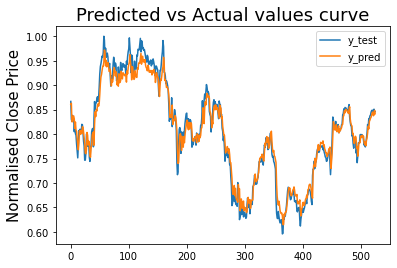

In [150]:
X_train_AAPL_3d,  y_AAPL_train, X_AAPL_test_3d, y_AAPL_test =makeFullDS('AAPL' ,data)
from keras.models import load_model

model_graph = load_model("model_r2_AAPL_BDLSTM.h5")
y_pred = model_graph.predict(X_AAPL_test_3d)
y_test = y_AAPL_test
plt.plot(y_test,label='y_test')
plt.plot(y_pred,label='y_pred')
plt.title('Predicted vs Actual values curve',fontsize='18')
plt.legend()
# plt.xlabel('Number of test points',fontsize='18')
plt.ylabel('Normalised Close Price',fontsize='15')
plt.show()



In [145]:
directionACC =   pd.DataFrame({'Stock' : [],'CNN' : [], 'MLP' : [], 'ODLSTM' : [], 'BDLSTM' : []})


In [146]:
from keras.models import load_model
for ticker in ['DOW', 'AAPL',"WFC","PFE"]: 
    directionACC.loc[len(directionACC.index)] = [ticker,0,0,0,0]
    X_train_AAPL_3d,  y_AAPL_train, X_AAPL_test_3d, y_AAPL_test =makeFullDS(ticker ,data)
    for modelType in ['CNN' ,  'ODLSTM' , 'BDLSTM']:
        

        model_graph = load_model("model_r2_{}_{}.h5".format(ticker,modelType))
        y_pred = model_graph.predict(X_AAPL_test_3d)
        y_test = y_AAPL_test

        count_same_dir = np.sum(np.equal(np.sign(np.array([y_test]).T-X_AAPL_test_3d[:,-1:,0]),np.sign(np.array([y_pred ]).T-X_AAPL_test_3d[:,-1:,0])))
        percentRightDir = count_same_dir/len(X_AAPL_test_3d)
        directionACC.loc[directionACC.Stock == ticker,modelType] = percentRightDir
    for modelType in ['MLP' ]:
        model_graph = load_model("model_r2_{}_{}.h5".format(ticker,modelType))
        y_pred = model_graph.predict(to2d(X_AAPL_test_3d))
        y_test = y_AAPL_test

        count_same_dir = np.sum(np.equal(np.sign(np.array([y_test]).T-X_AAPL_test_3d[:,-1:,0]),np.sign(np.array([y_pred ]).T-X_AAPL_test_3d[:,-1:,0])))
        percentRightDir = count_same_dir/len(X_AAPL_test_3d)
        directionACC.loc[directionACC.Stock == ticker,modelType] = percentRightDir


(1762, 1)
(1762, 1)
(1762, 1)
(1762, 1)


In [147]:
for ticker in ['NFLX', 'AMZN',"BA","JPM","JNJ"]:
    X_train_AAPL_3d,  y_AAPL_train, X_AAPL_test_3d, y_AAPL_test =makeFullDS(ticker ,data)
    directionACC.loc[len(directionACC.index)] = [ticker,0,0,0,0]
    for modelType in ['CNN' ,  'ODLSTM' , 'BDLSTM']:
        

        model_graph = load_model("model_r5_{}_{}.h5".format(ticker,modelType))
        y_pred = model_graph.predict(X_AAPL_test_3d)
        y_test = y_AAPL_test

        count_same_dir = np.sum(np.equal(np.sign(np.array([y_test]).T-X_AAPL_test_3d[:,-1:,0]),np.sign(np.array([y_pred ]).T-X_AAPL_test_3d[:,-1:,0])))
        percentRightDir = count_same_dir/len(X_AAPL_test_3d)
        directionACC.loc[directionACC.Stock == ticker,modelType] = percentRightDir
    for modelType in ['MLP' ]:
        model_graph = load_model("model_r5_{}_{}.h5".format(ticker,modelType))
        y_pred = model_graph.predict(to2d(X_AAPL_test_3d))
        y_test = y_AAPL_test

        count_same_dir = np.sum(np.equal(np.sign(np.array([y_test]).T-X_AAPL_test_3d[:,-1:,0]),np.sign(np.array([y_pred ]).T-X_AAPL_test_3d[:,-1:,0])))
        percentRightDir = count_same_dir/len(X_AAPL_test_3d)
        directionACC.loc[directionACC.Stock == ticker,modelType] = percentRightDir


(1762, 1)
(1762, 1)
(1762, 1)
(1762, 1)
(1762, 1)


In [148]:
directionACC

,Stock,CNN,MLP,ODLSTM,BDLSTM
0,DOW,0.501901,0.490494,0.496198,0.488593
1,AAPL,0.517110,0.507605,0.532319,0.547529
2,WFC,0.500000,0.549430,0.524715,0.545627
3,PFE,0.522814,0.492395,0.501901,0.513308
4,NFLX,0.515209,0.547529,0.513308,0.526616
5,AMZN,0.488593,0.511407,0.501901,0.465779
6,BA,0.488593,0.534221,0.528517,0.543726
7,JPM,0.532319,0.509506,0.511407,0.486692
8,JNJ,0.507605,0.551331,0.528517,0.513308
